## Demonstrate subtraction on a few hand-picked examples

In [16]:
import h5py 
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
import grid_utils as util
import subtract_utils
import circuitmap as cm
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec

In [17]:
datapath = '../data/masato/B6WT_AAV_hsyn_chrome2f_gcamp8/preprocessed/220308_B6_Chrome2fGC8_030822_Cell2_opsPositive_A_planes_cmReformat.mat'
subtractr_checkpoint = './grid_artifacts/happy-ptolemy-8225/happy-ptolemy-8225-exp0/scripts/lightning_logs/version_0/checkpoints/epoch=184-step=520404.ckpt'
demixer_checkpoint = '../../circuit_mapping/demixers/nwd_ee_ChroME1.ckpt'
pscs, stim_mat, powers, targets = util.load_h5_data(datapath)


In [18]:

net = cm.NeuralDemixer(
    path=subtractr_checkpoint,
    unet_args=dict(
            down_filter_sizes=(16, 32, 64, 128),
            up_filter_sizes=(64, 32, 16, 4),
    ))
results = subtract_utils.run_network_subtraction_pipeline(
    pscs, powers, targets, stim_mat,
    demixer_checkpoint, net,
    run_raw_demix=True,
)

Demixing PSC traces... complete (elapsed time 66.35s, device=cpu).


## show result of running demixer only

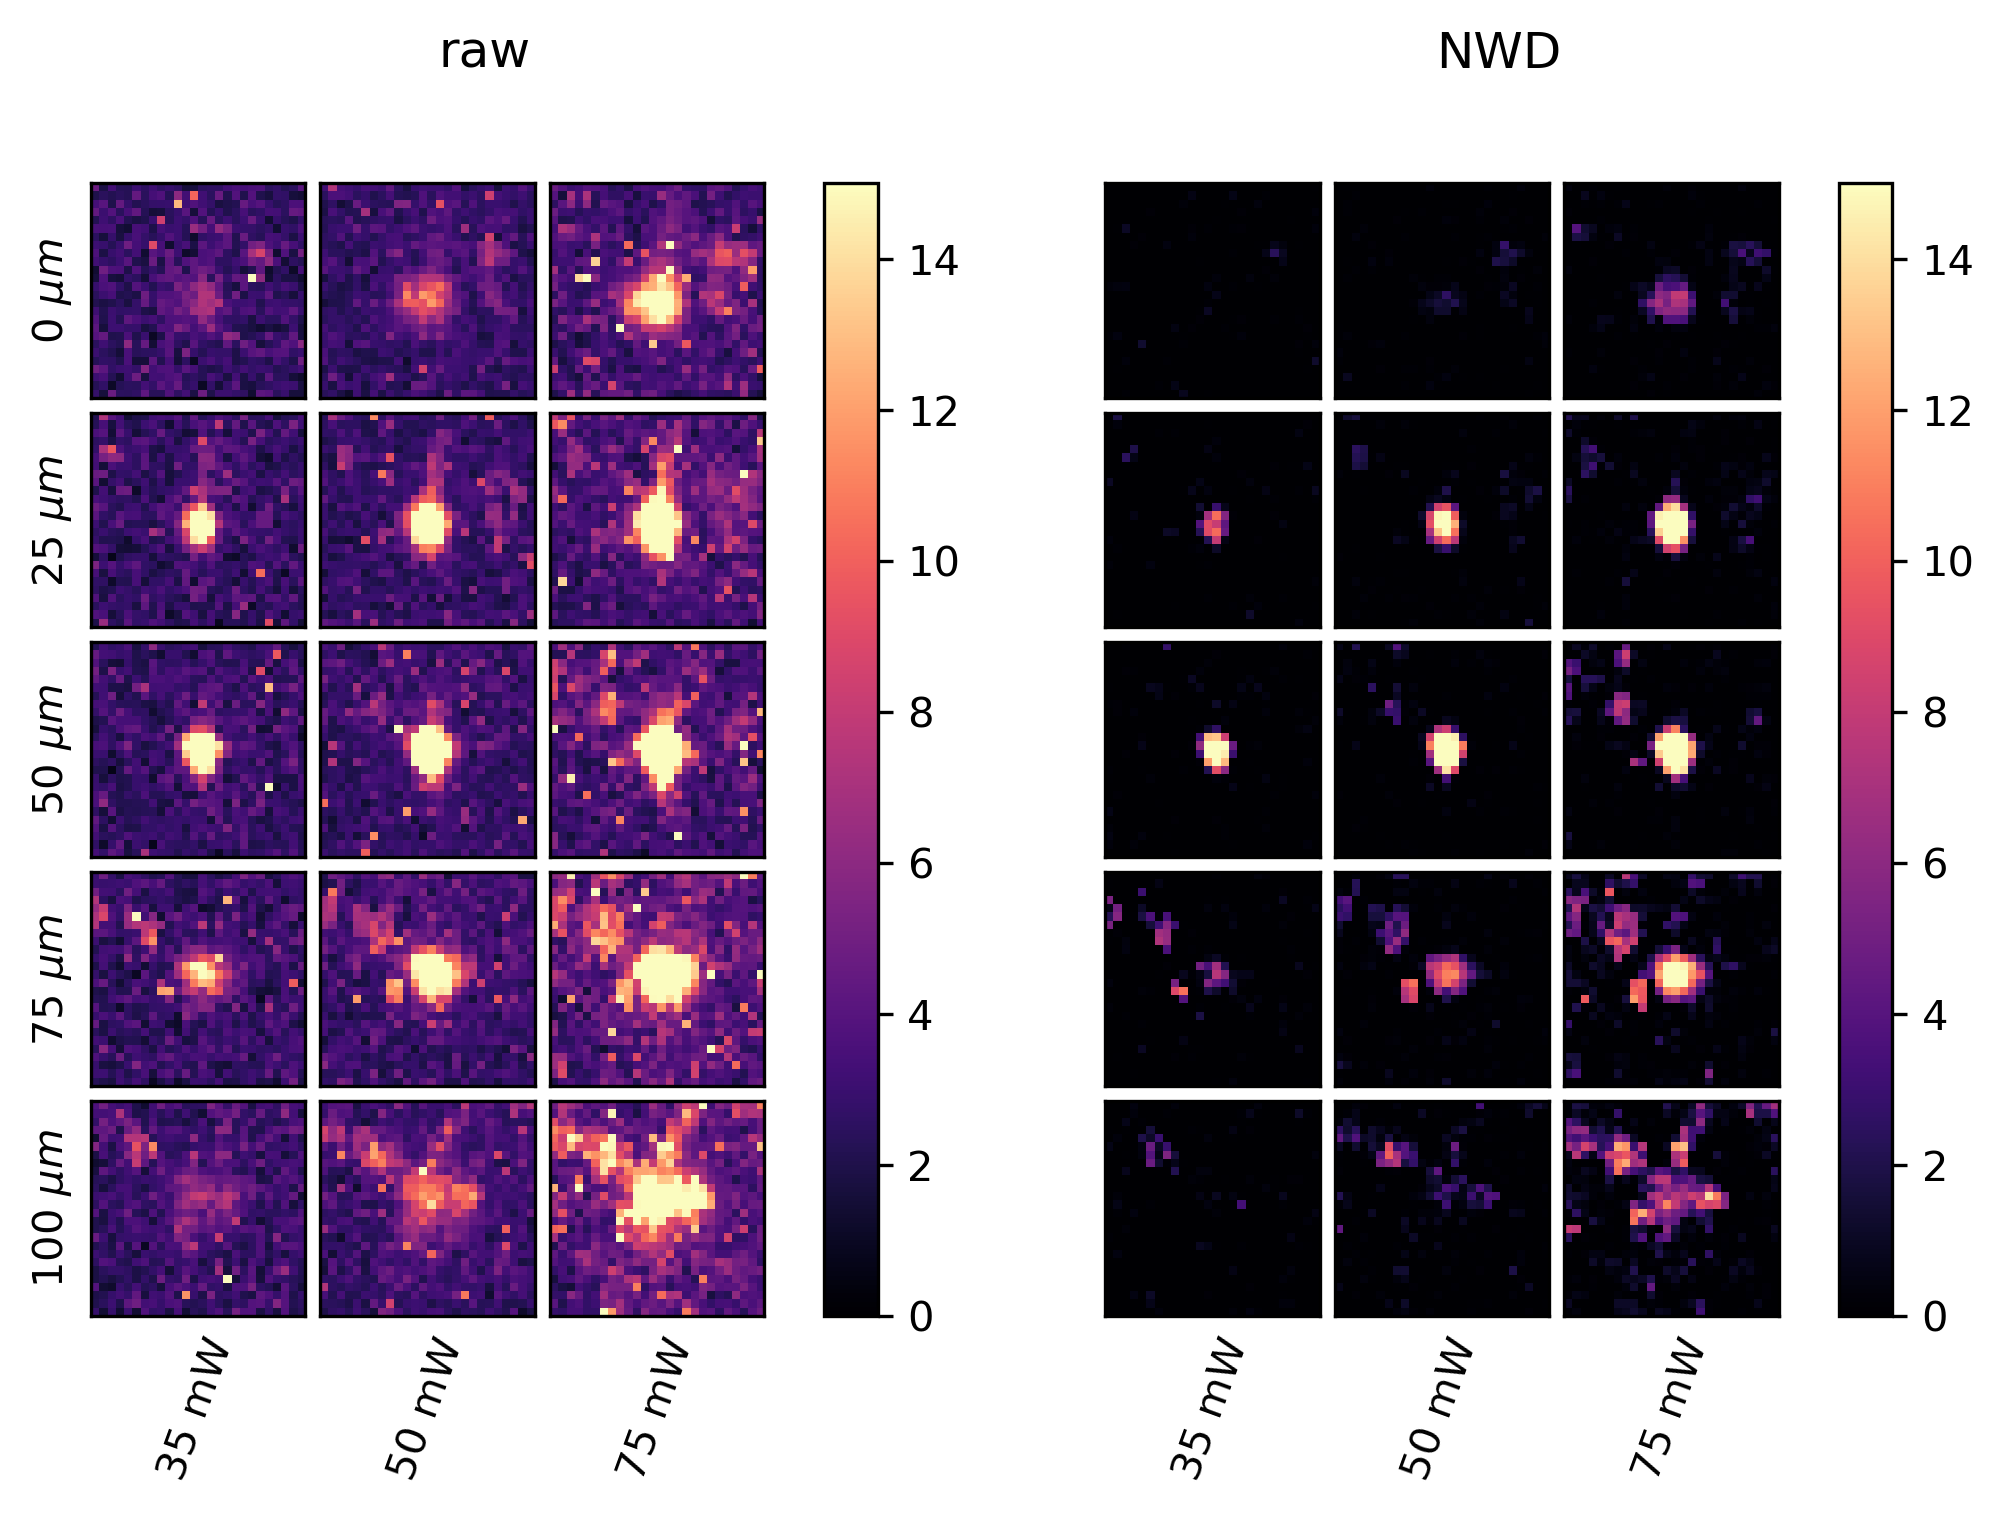

In [22]:
num_planes = results['raw_map'].shape[-1]
fig1 = plt.figure(figsize=(4 * 2, num_planes), dpi=300, facecolor='white')
plot_multi_means(fig1,
[
    results['raw_map'],
    results['raw_demixed_map'],

], 
np.arange(num_planes),
zs=np.unique(targets[:,-1]),
map_names=['raw', 'NWD'],
cmaps=['magma', 'magma', 'magma', 'magma'],
vranges=[(0,15), (0,15), (0,15), (0,15)],
powers=np.unique(powers),
show_powers=(True, True, True, True),
)

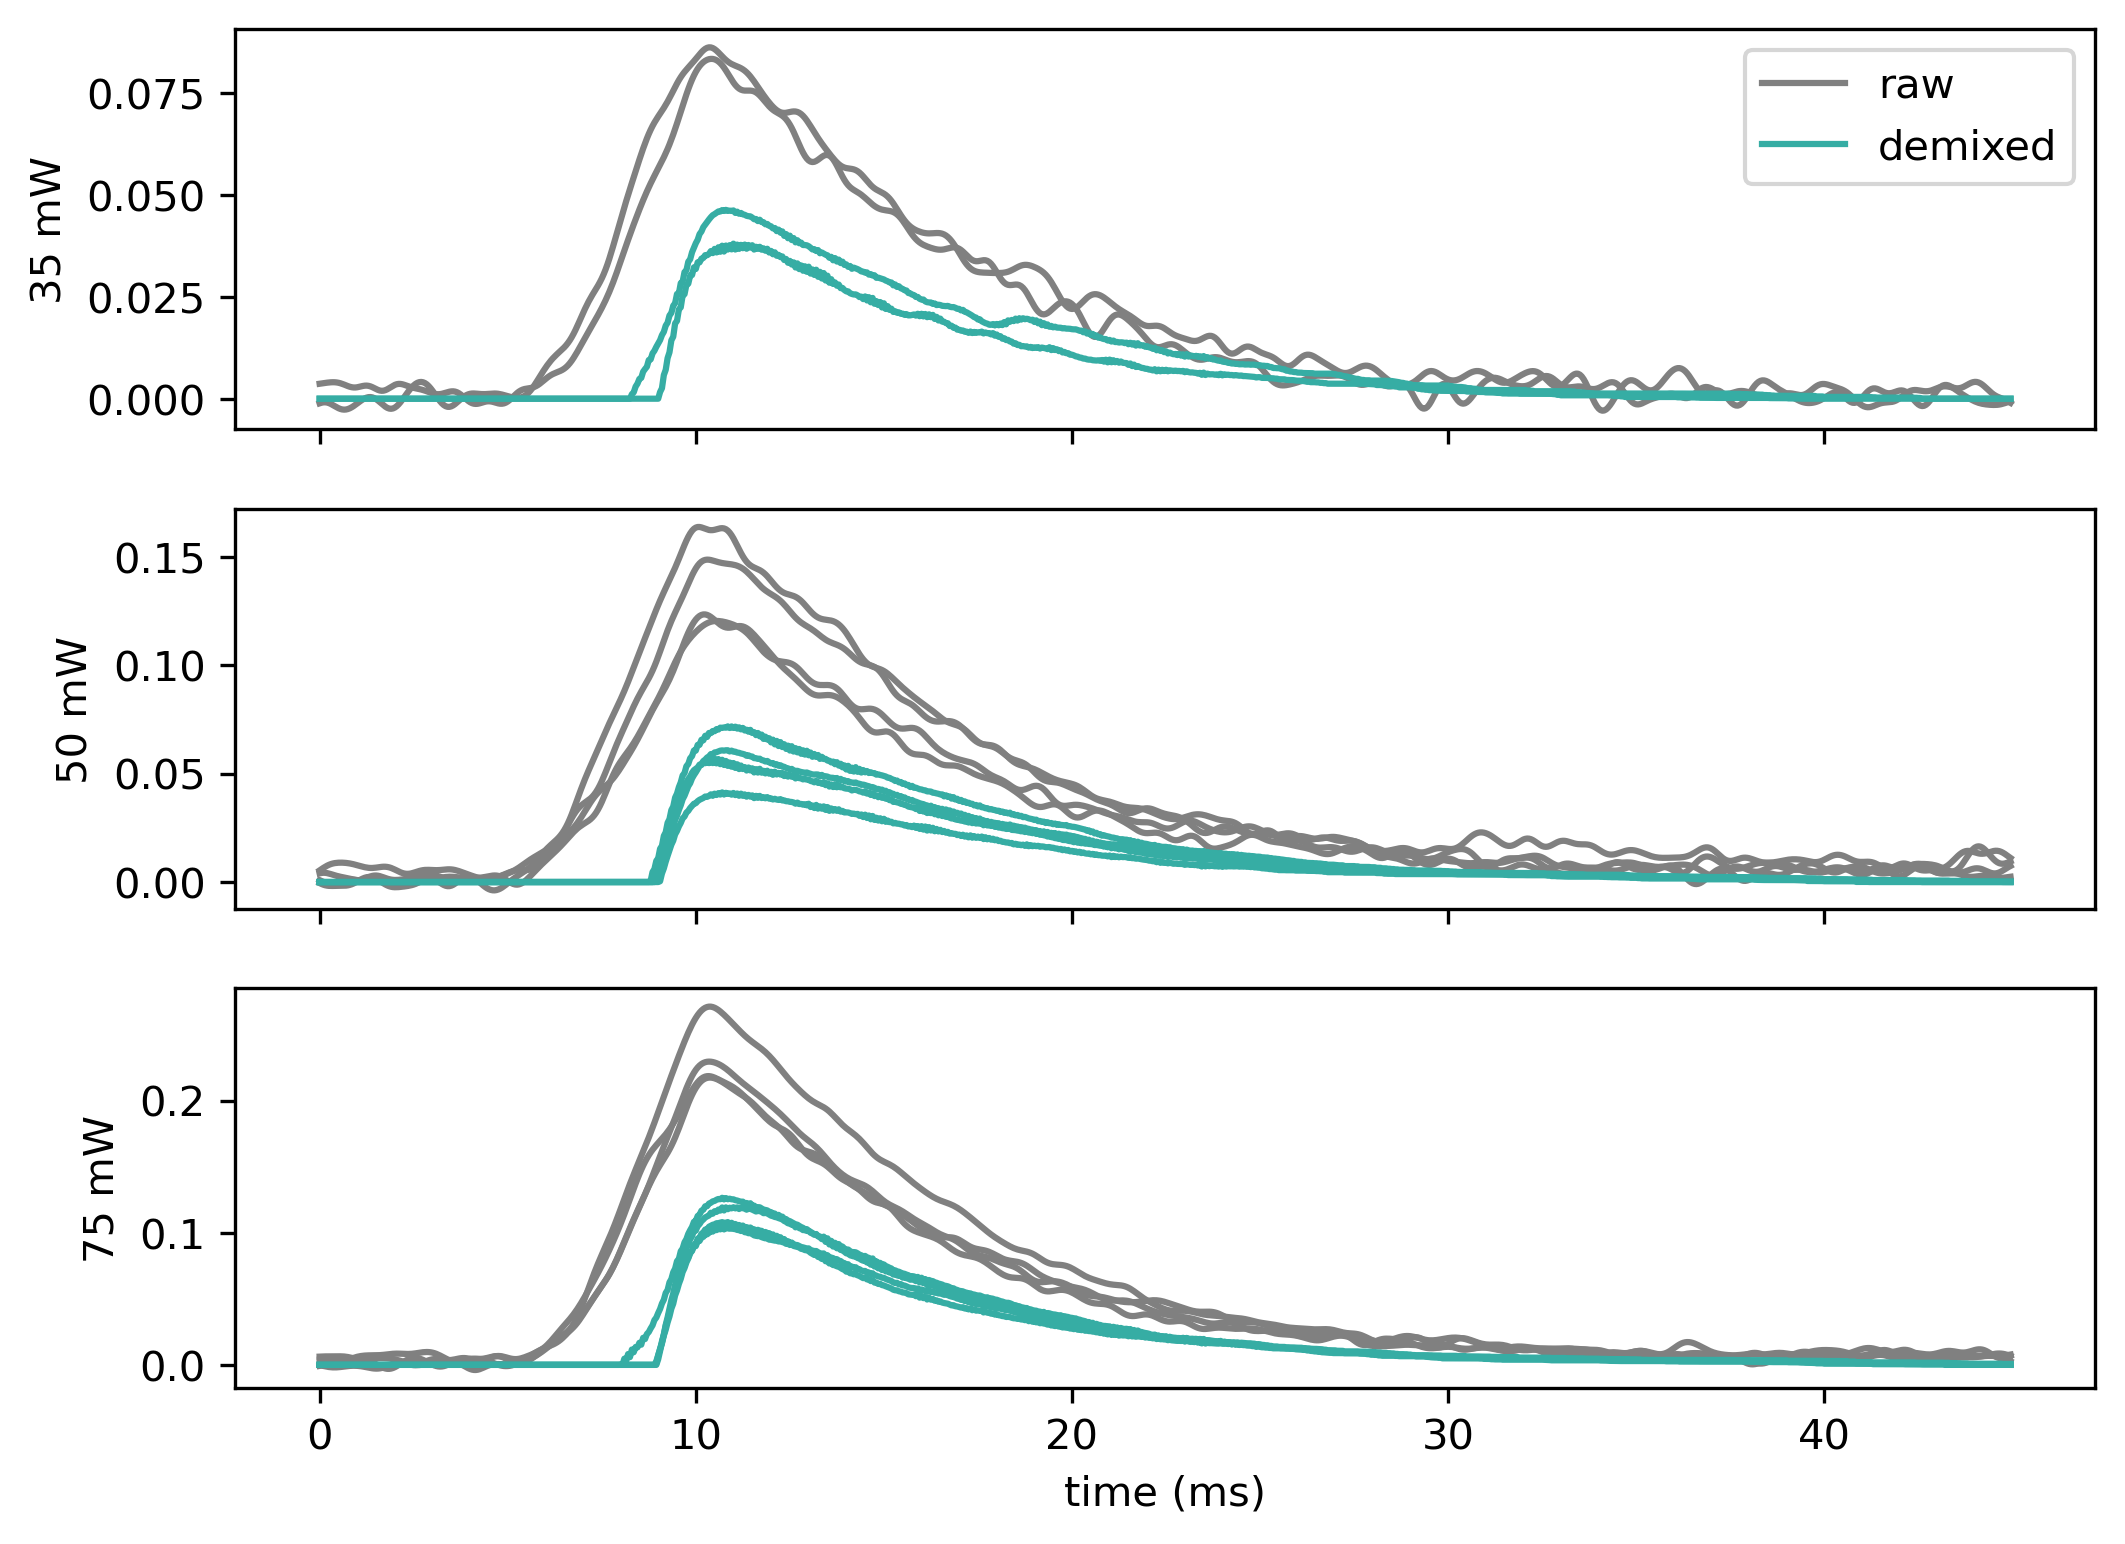

In [45]:
import seaborn as sns
palette = sns.husl_palette(n_colors=2)
fig, axs = plt.subplots(nrows=len(np.unique(powers)), ncols=1, dpi=300, figsize=(8,6), sharex=True)
time = np.arange(0,900) * 0.05
for i, p in enumerate(np.unique(powers)):
    axs[i].plot(time, results['raw_tensor'][i, 13,13,3, :].reshape(-1, 900).T ,
        color='grey', label='raw')
    axs[i].plot(time, results['raw_demixed_tensor'][i, 13,13,3,:].reshape(-1, 900).T,
        color=palette[1], label='demixed')
    axs[i].set_ylabel('%d mW' % p)

plt.xlabel('time (ms)')

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))

legend_without_duplicate_labels(axs[0])


In [19]:
def plot_multi_means(fig, mean_maps, depth_idxs,
                     roi_bounds=None,
                     zs=None, zlabels=None, powers=None, map_names=None, cmaps='viridis',
                     vranges=None, cbar_labels=None, show_powers=None):
    if show_powers is None:
        show_powers = True * [len(mean_maps)]

    # allow option to pass separate cmaps for each grid plot
    if not isinstance(cmaps, list):
        cmaps = len(mean_maps) * [cmaps]

    for mean_idx, mean_map, cmap in zip(
            range(len(mean_maps)), mean_maps, cmaps):

        num_powers, _, _, num_planes = mean_map.shape
        num_planes_to_plot = len(depth_idxs)
        assert num_planes_to_plot <= num_planes

        # Create a new grid for each mean map
        subplot_args = int("1" + str(len(mean_maps)) + str(mean_idx + 1))
        ax_curr = plt.subplot(subplot_args)

        if powers is not None and map_names is not None:
            ax_curr.set_title(map_names[mean_idx], y=1.08)

        plt.axis('off')

        grid = ImageGrid(fig, subplot_args,  # similar to subplot(111)
                         # creates 2x2 grid of axes
                         nrows_ncols=(num_planes_to_plot, num_powers),
                         axes_pad=0.05,  # pad between axes in inch.
                         cbar_mode='single',
                         cbar_pad=0.2
                         )
        if vranges is not None:
            min_val, max_val = vranges[mean_idx]
        else:
            min_val = np.nanmin(mean_map)
            max_val = np.nanmax(mean_map)

        for j, ax in enumerate(grid):
            row = j // num_powers
            col = j % num_powers
            ax.set_xticks([])
            ax.set_yticks([])
#             ax.set_frame_on(False)

            # optionally add labels
            if (zs is not None) and col == 0 and mean_idx == 0:
                ax.set_ylabel('%d ' % zs[depth_idxs[row]] + r'$\mu m $')
            elif (zlabels is not None) and col == 0 and mean_idx == 0:
                ax.set_ylabel(zlabels[row])

            if powers is not None and row == num_planes_to_plot - 1 and show_powers[mean_idx]:
                ax.set_xlabel('%d mW' % powers[col], rotation=70)

            im = ax.imshow(mean_map[col, :, :, depth_idxs[row]],
                           origin='lower', vmin=min_val, vmax=max_val, cmap=cmap)

            cbar = grid[0].cax.colorbar(im)

            if roi_bounds is not None:
                x1, y1, x2, y2 = roi_bounds
                rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                    linewidth=1, edgecolor='white', linestyle='--', facecolor='none')

                # Add the patch to the Axes
                ax.add_patch(rect)

        if cbar_labels is not None:
            cbar.set_label(cbar_labels[mean_idx], rotation=90, loc='top')



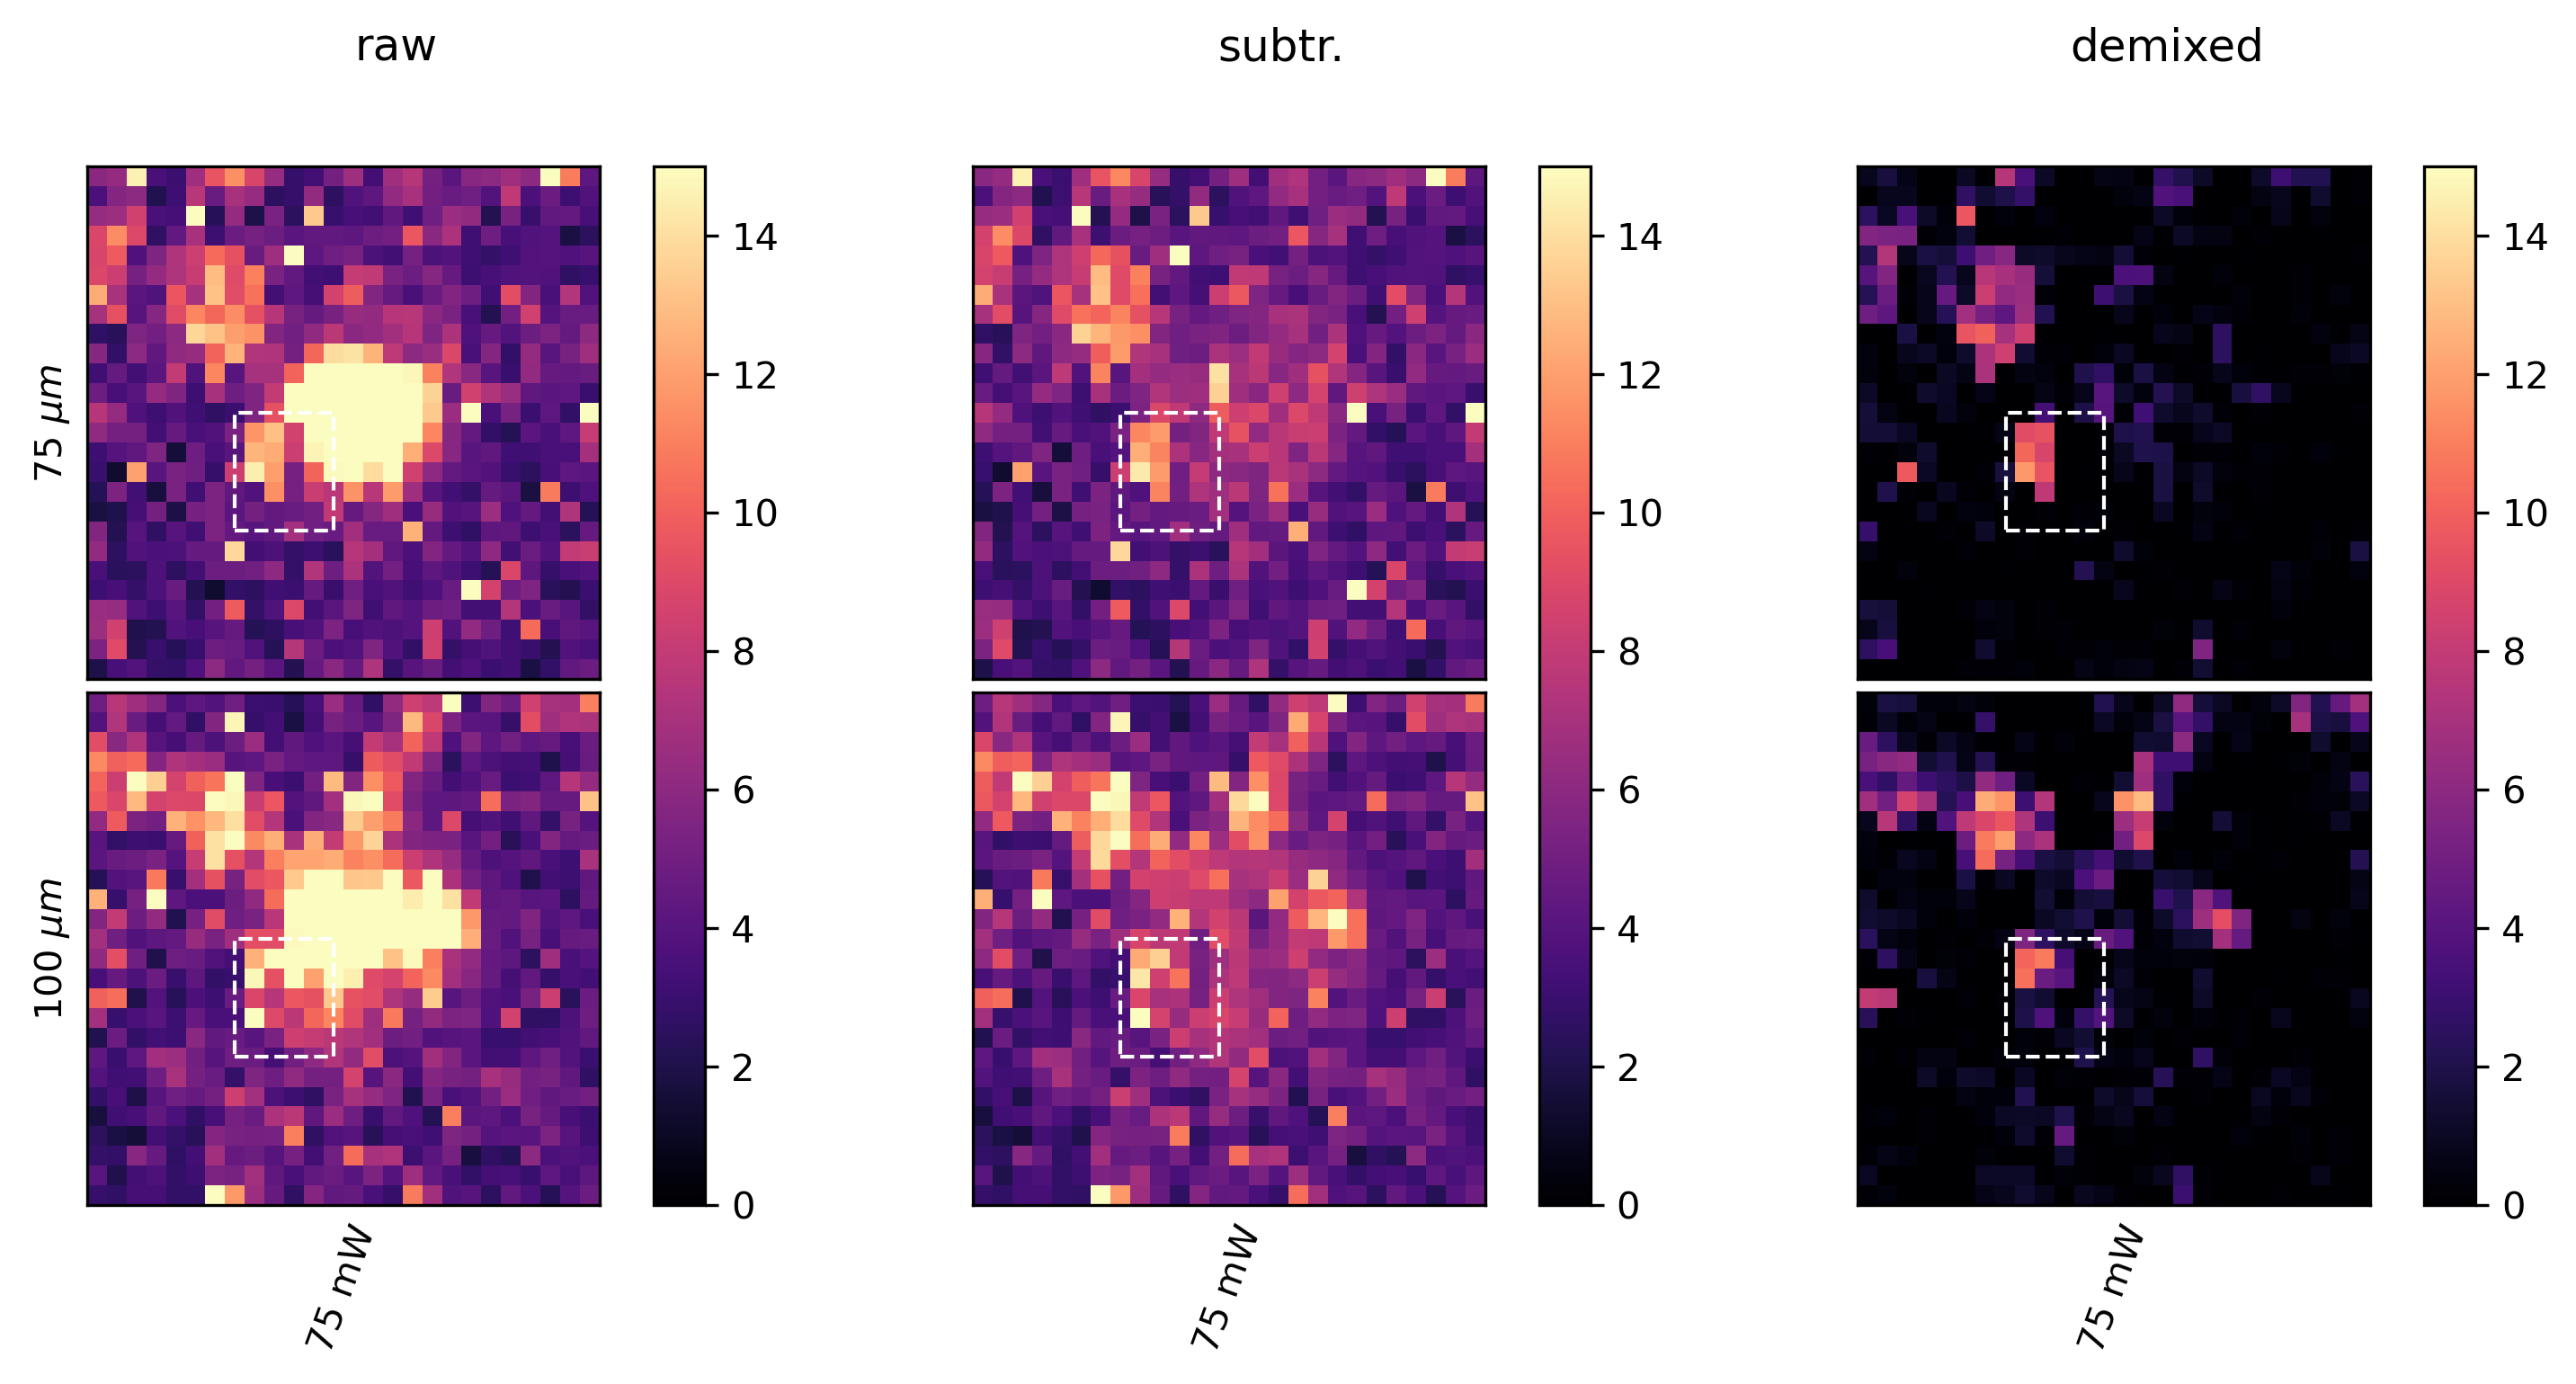

In [109]:
roi_bounds = (7, 7, 12, 13)
num_planes = results['raw_map'].shape[-1]
fig1 = plt.figure(figsize=(4 * 3, num_planes), dpi=300, facecolor='white')
plot_multi_means(fig1,
[
    results['raw_map'][2:3],
    results['subtracted_map'][2:3],
    results['demixed_map'][2:3],
], 
[3,4],
zs=np.unique(targets[:,-1]),
map_names=['raw', 'subtr.', 'demixed'],
cmaps=['magma', 'magma', 'magma', 'magma'],
# cbar_labels=['EPSQ (nC)'],
# zlabels=['subtr', 'demix'],
# map_names=['raw', 'subtr', 'demix'],
vranges=[(0,15), (0,15), (0,15), (0,15)],
powers=np.unique(powers)[2:3],
show_powers=(True, True, True, True),
roi_bounds=roi_bounds,
)

## show multispot data for this cell

In [135]:
ms_path = '../data/masato/B6WT_AAV_hsyn_chrome2f_gcamp8/preprocessed/220308_B6_Chrome2fGC8_030822_Cell2_opsPositive_A_grid_cmReformat.mat'
demixer_checkpoint = '../../circuit_mapping/demixers/nwd_ee_ChroME1.ckpt'
pscs, stim_mat, powers, targets = util.load_h5_data(ms_path)

net = cm.NeuralDemixer(
    path=subtractr_checkpoint,
    unet_args=dict(
            down_filter_sizes=(16, 32, 64, 128),
            up_filter_sizes=(64, 32, 16, 4),
    ))

results = subtract_utils.run_network_subtraction_pipeline(
    pscs, powers, targets, stim_mat,
    demixer_checkpoint, net,
    run_raw_demix=True,
)

Demixing PSC traces... complete (elapsed time 27.62s, device=cpu).


In [177]:
from sklearn.linear_model import Lasso
import time

def circuitmap_lasso(stim_mat, pscs, alpha=1):
    """
    For each power, return a list of inferred weights via L1 regularized regression.
    The L1 penalty is determined by K-fold cross validation.
    
    returns:
        responses: (num_powers x num_cells) inferred weight at each power
    """
    powers = np.unique(stim_mat.ravel())[1:] # exclude zero
    num_powers = len(powers)
    N = stim_mat.shape[0]
    responses = np.zeros((num_powers, N))
    models = []
    for pidx, power in enumerate(powers):
        
        curr_trials = np.max(stim_mat, axis=0) == power
        curr_stim = stim_mat[:,curr_trials]
        curr_pscs = pscs[curr_trials,:]
        stim_binarized = curr_stim > 0 
        
        # fit lasso with cross val
        print('Starting lasso CV')
        start_time = time.time()
        y = np.trapz(curr_pscs, axis=-1)
        model = Lasso(alpha=alpha, fit_intercept=True, normalize=True, positive=True).fit(stim_binarized.T, y)
        end_time = time.time() - start_time
        print('CV at single power took %f secs' % end_time)
        responses[pidx] = model.coef_
        models.append(model)
        
    return responses, models

In [189]:
raw_resp, _ = circuitmap_lasso(stim_mat, results['raw_matrix'], alpha=1e-3)
subtracted_resp, _ = circuitmap_lasso(stim_mat, results['subtracted_matrix'], alpha=5e-4)
demixed_resp, _ = circuitmap_lasso(stim_mat, results['demixed_matrix'], alpha=5e-4)


Starting lasso CV
CV at single power took 0.317779 secs
Starting lasso CV
CV at single power took 0.322345 secs
Starting lasso CV
CV at single power took 0.351604 secs
Starting lasso CV
CV at single power took 0.334475 secs
Starting lasso CV
CV at single power took 0.339941 secs
Starting lasso CV
CV at single power took 0.419958 secs
Starting lasso CV
CV at single power took 0.293508 secs
Starting lasso CV
CV at single power took 0.278239 secs
Starting lasso CV
CV at single power took 0.293571 secs


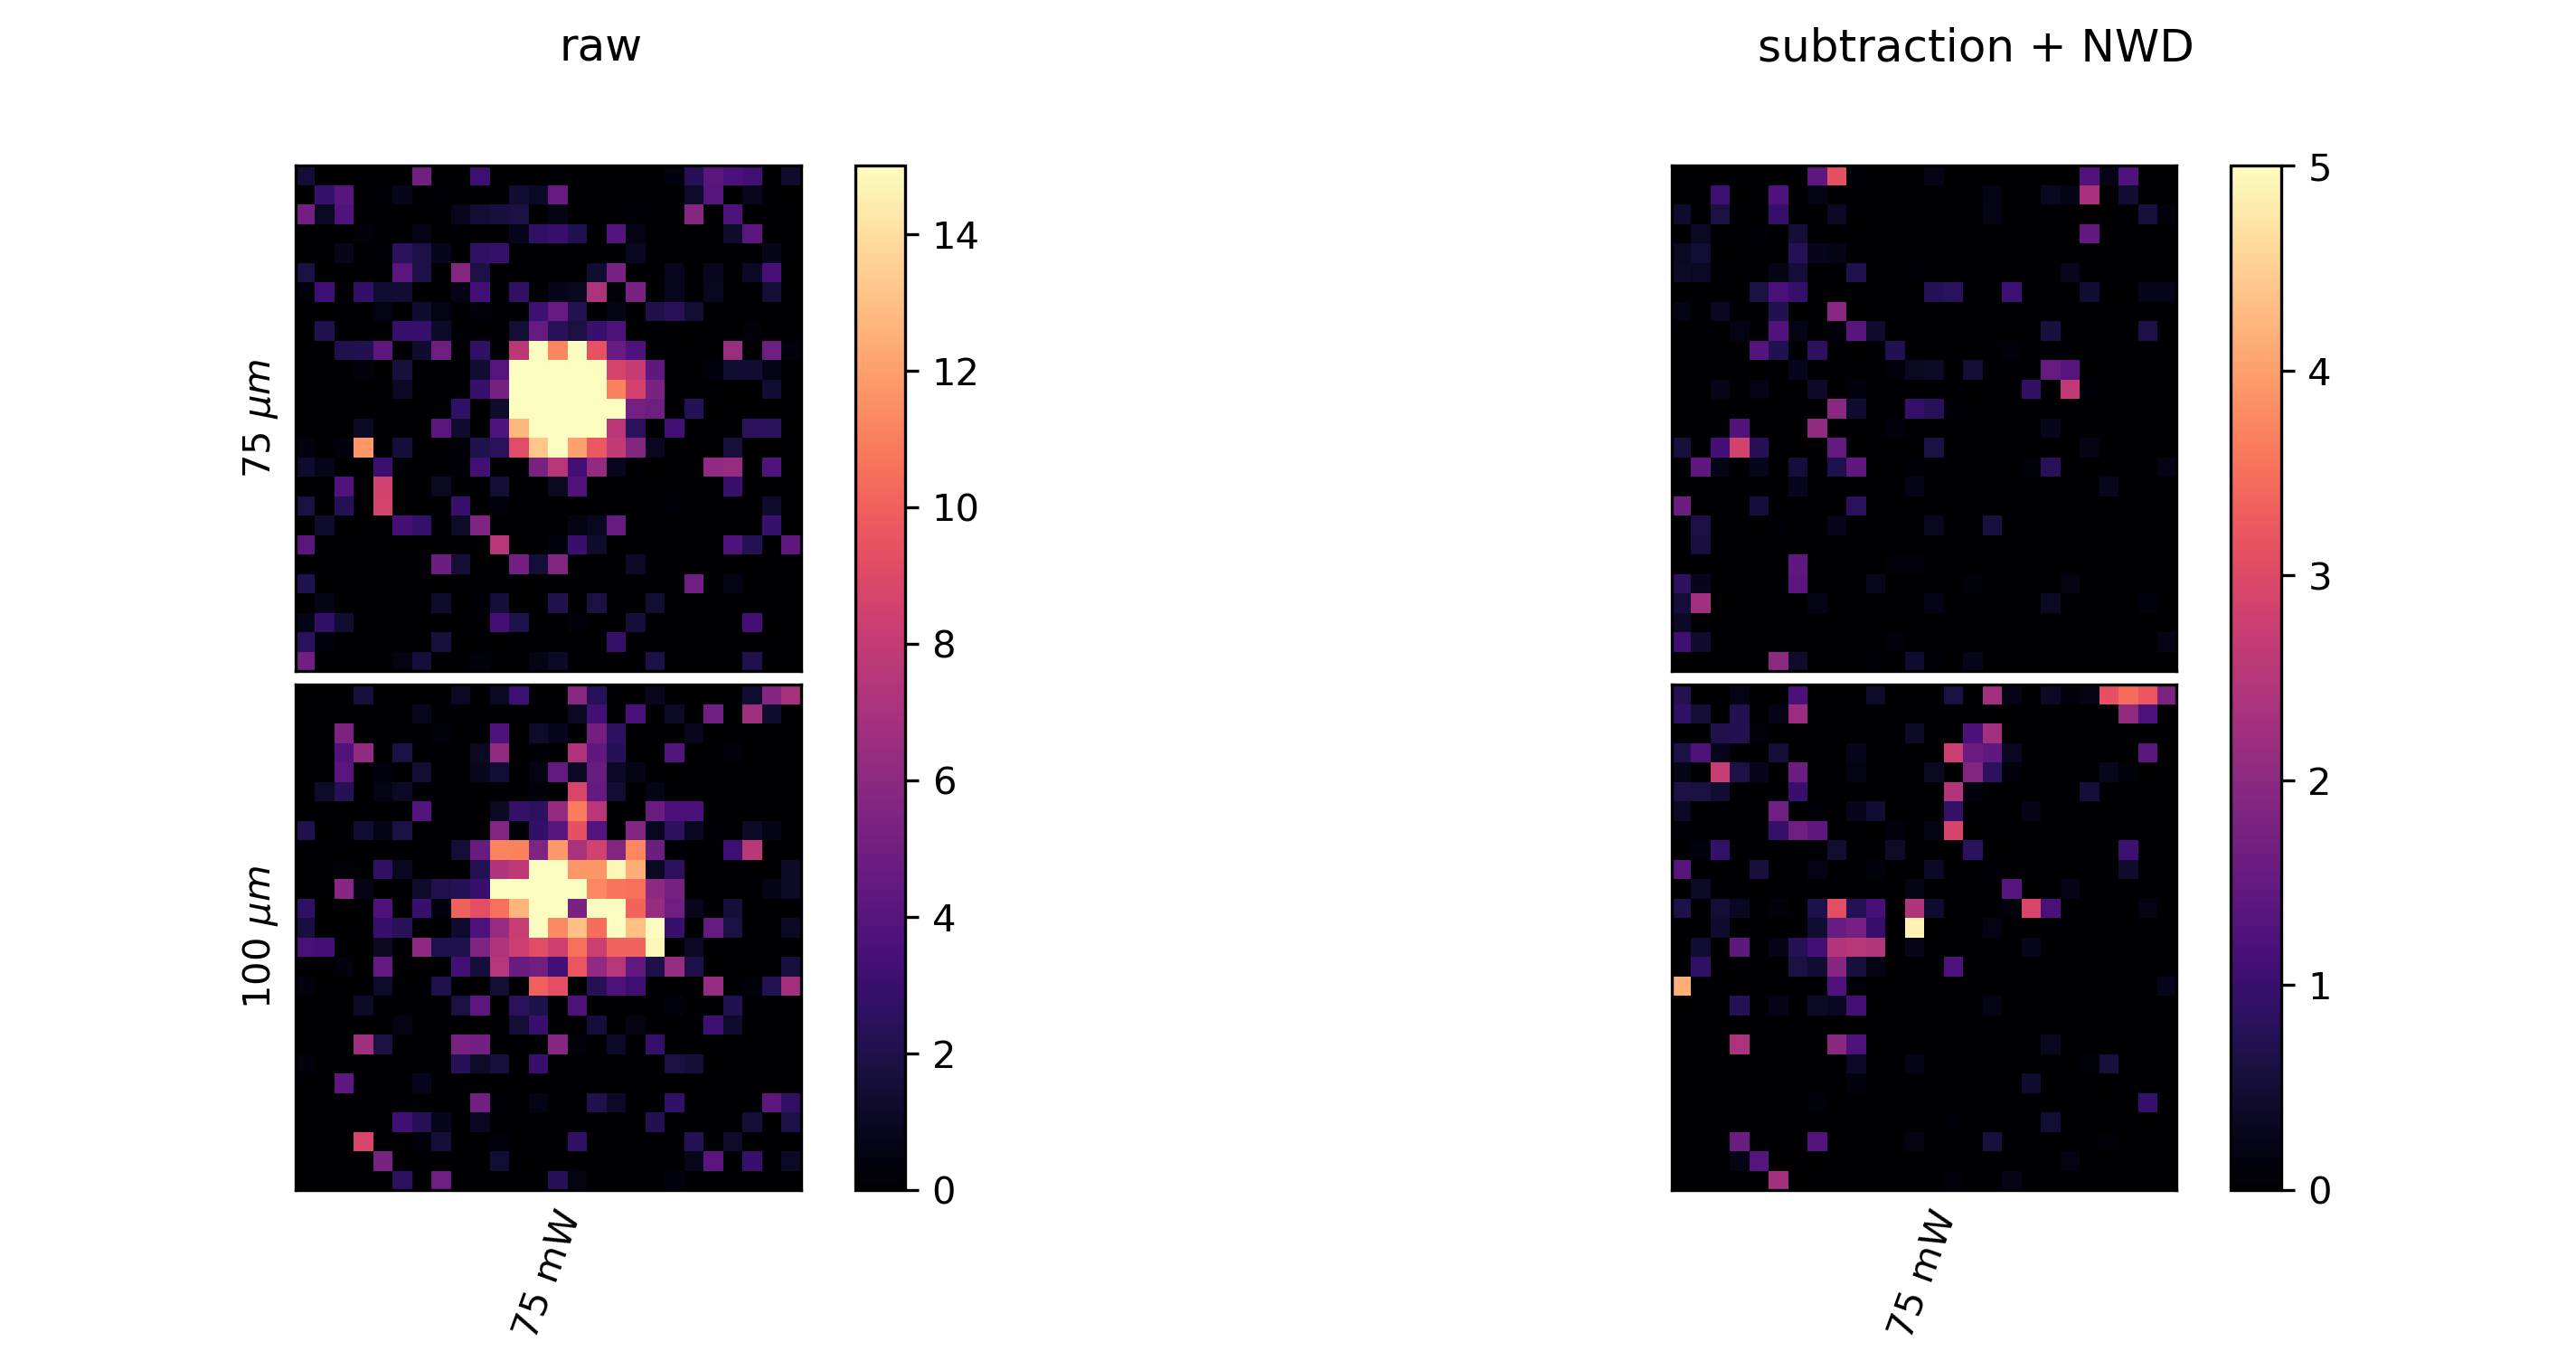

In [195]:
num_planes = results['raw_map'].shape[-1]
fig1 = plt.figure(figsize=(4 * 3, num_planes), dpi=300, facecolor='white')
plot_multi_means(fig1,
[
    raw_resp.reshape(results['raw_map'].shape)[2:3],
    # subtracted_resp.reshape(results['raw_map'].shape)[2:3],
    demixed_resp.reshape(results['raw_map'].shape)[2:3],
], 
# np.arange(5),
[3,4],
zs=np.unique(targets[:,-1]),
map_names=['raw', 'subtraction + NWD', 'demixed'],
cmaps=['magma', 'magma', 'magma', 'magma'],
# cbar_labels=['EPSQ (nC)'],
# zlabels=['subtr', 'demix'],
# map_names=['raw', 'subtr', 'demix'],
vranges=[(0,15), (0,5), (0,15), (0,15)],
powers=np.unique(powers)[-1:],
show_powers=(True, True, True, True),
)

**show traces from singlespot**

In [110]:
# show ROI and traces
plt.rcParams.update(plt.rcParamsDefault)
import seaborn as sns
sns.set_palette('deep')



roi_index = np.s_[2:, roi_bounds[1]:roi_bounds[3], roi_bounds[0]:roi_bounds[2], 3:, :]
raw_tensor_roi = results['raw_tensor'][roi_index]
raw_map_roi = subtract_utils.traces_tensor_to_map(raw_tensor_roi)

subtracted_tensor_roi = results['subtracted_tensor'][roi_index]
subtracted_map_roi = subtract_utils.traces_tensor_to_map(subtracted_tensor_roi)

demixed_tensor_roi = results['demixed_tensor'][roi_index]
demixed_map_roi = subtract_utils.traces_tensor_to_map(demixed_tensor_roi)

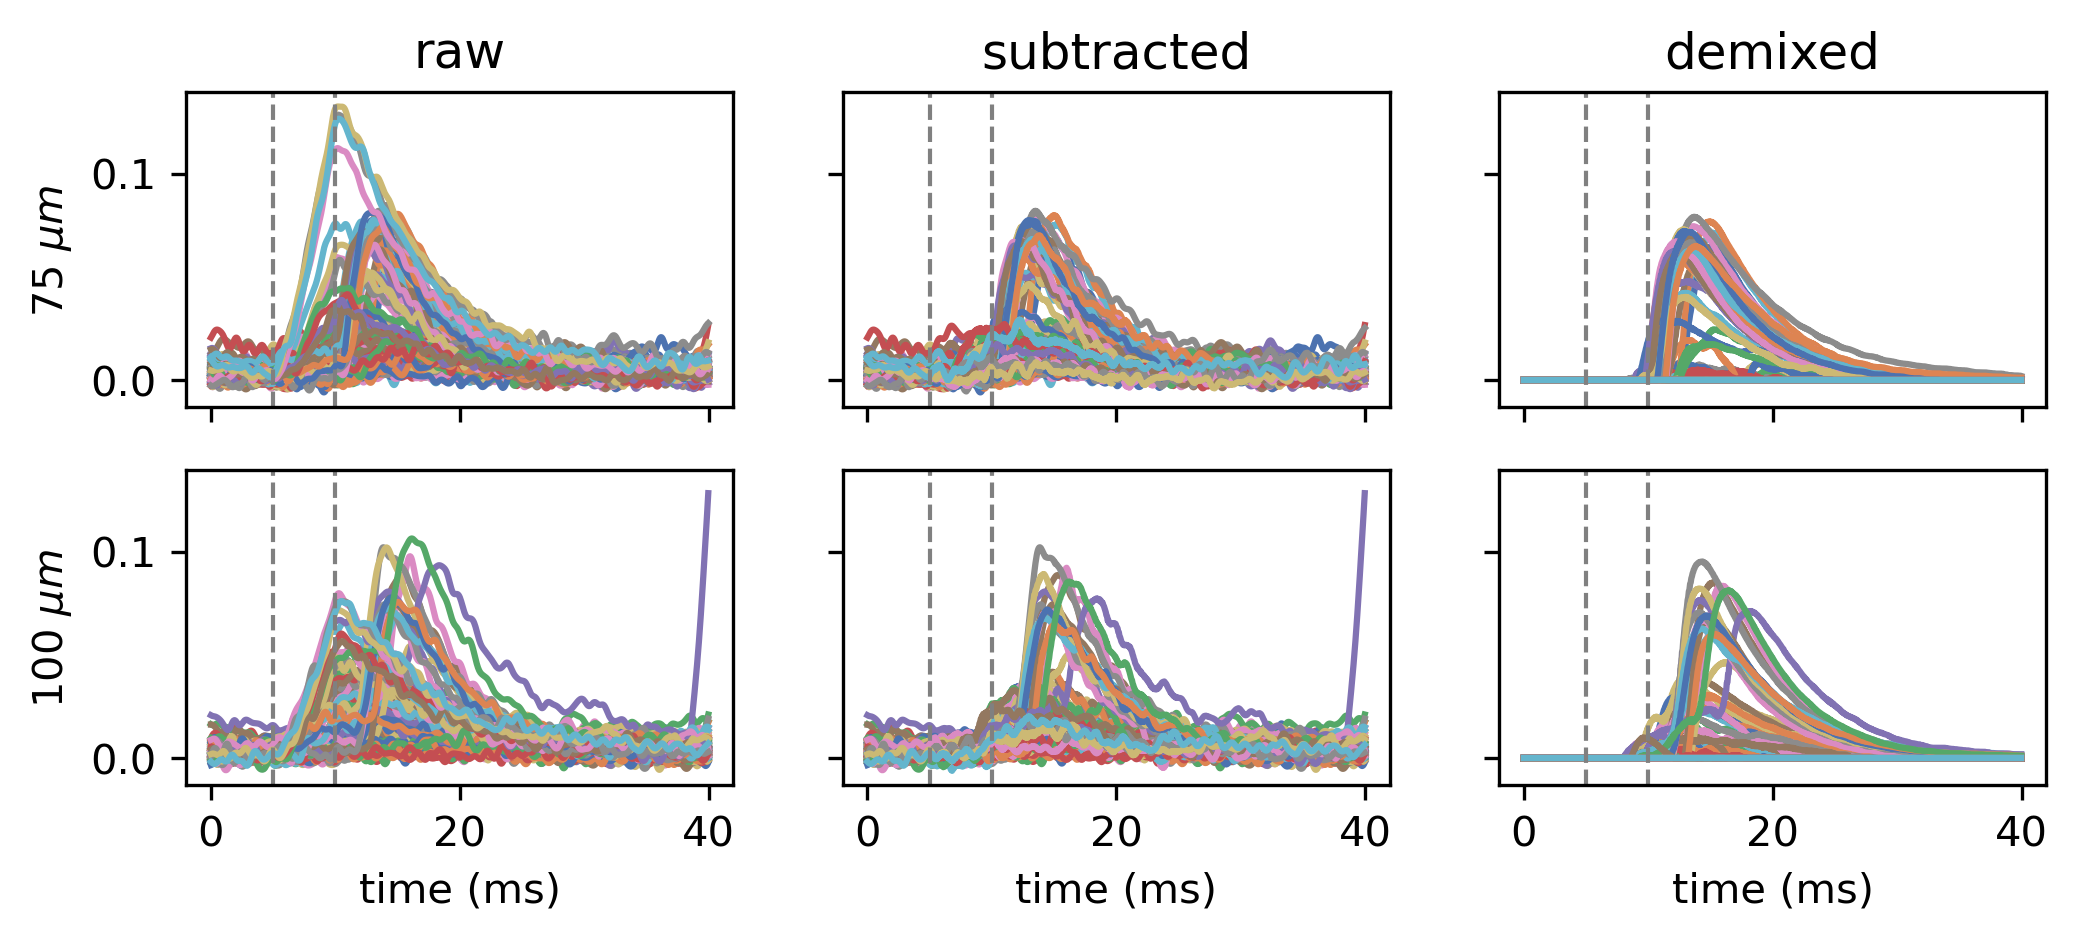

In [111]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(8,3), dpi=300, sharex=True, sharey=True)
tensors_list = [raw_tensor_roi, subtracted_tensor_roi, demixed_tensor_roi]
labels = ['raw', 'subtracted', 'demixed']
zs=np.unique(targets[:,-1])[3:5]
frame_cutoff = 800
msecs_per_samples = 0.05
time = np.arange(frame_cutoff) * msecs_per_samples
for i in range(2):
    for j in range(3):
        axs[i,j].plot(time,
            tensors_list[j][:, :, :, i, :, :frame_cutoff].reshape(-1, frame_cutoff).T,
        )

        axs[i,j].axvline(x=5, linestyle='--', color='grey', linewidth=1.)
        axs[i,j].axvline(x=10, linestyle='--', color='grey', linewidth=1.)

        if j == 0:
            axs[i,j].set_ylabel('%d ' % zs[i] + r'$\mu m $')

        if i == 0:
            axs[i,j].set_title(labels[j])

        if i == 1:
            axs[i,j].set_xlabel('time (ms)')

        

## Dataset 2

In [131]:
datapath = '../data/masato/B6WT_AAV_hsyn_chrome2f_gcamp8/preprocessed/220308_B6_Chrome2fGC8_030822_Cell1_opsPositive_A_planes_cmReformat.mat'
subtractr_checkpoint = './grid_artifacts/happy-ptolemy-8225/happy-ptolemy-8225-exp0/scripts/lightning_logs/version_0/checkpoints/epoch=184-step=520404.ckpt'
demixer_checkpoint = '../../circuit_mapping/demixers/nwd_ee_ChroME1.ckpt'
pscs, stim_mat, powers, targets = util.load_h5_data(datapath)

net = cm.NeuralDemixer(
    path=subtractr_checkpoint,
    unet_args=dict(
            down_filter_sizes=(16, 32, 64, 128),
            up_filter_sizes=(64, 32, 16, 4),
    ))
results = subtract_utils.run_network_subtraction_pipeline(
    pscs, powers, targets, stim_mat,
    demixer_checkpoint, net,
    run_raw_demix=False,
)

Demixing PSC traces... complete (elapsed time 85.32s, device=cpu).


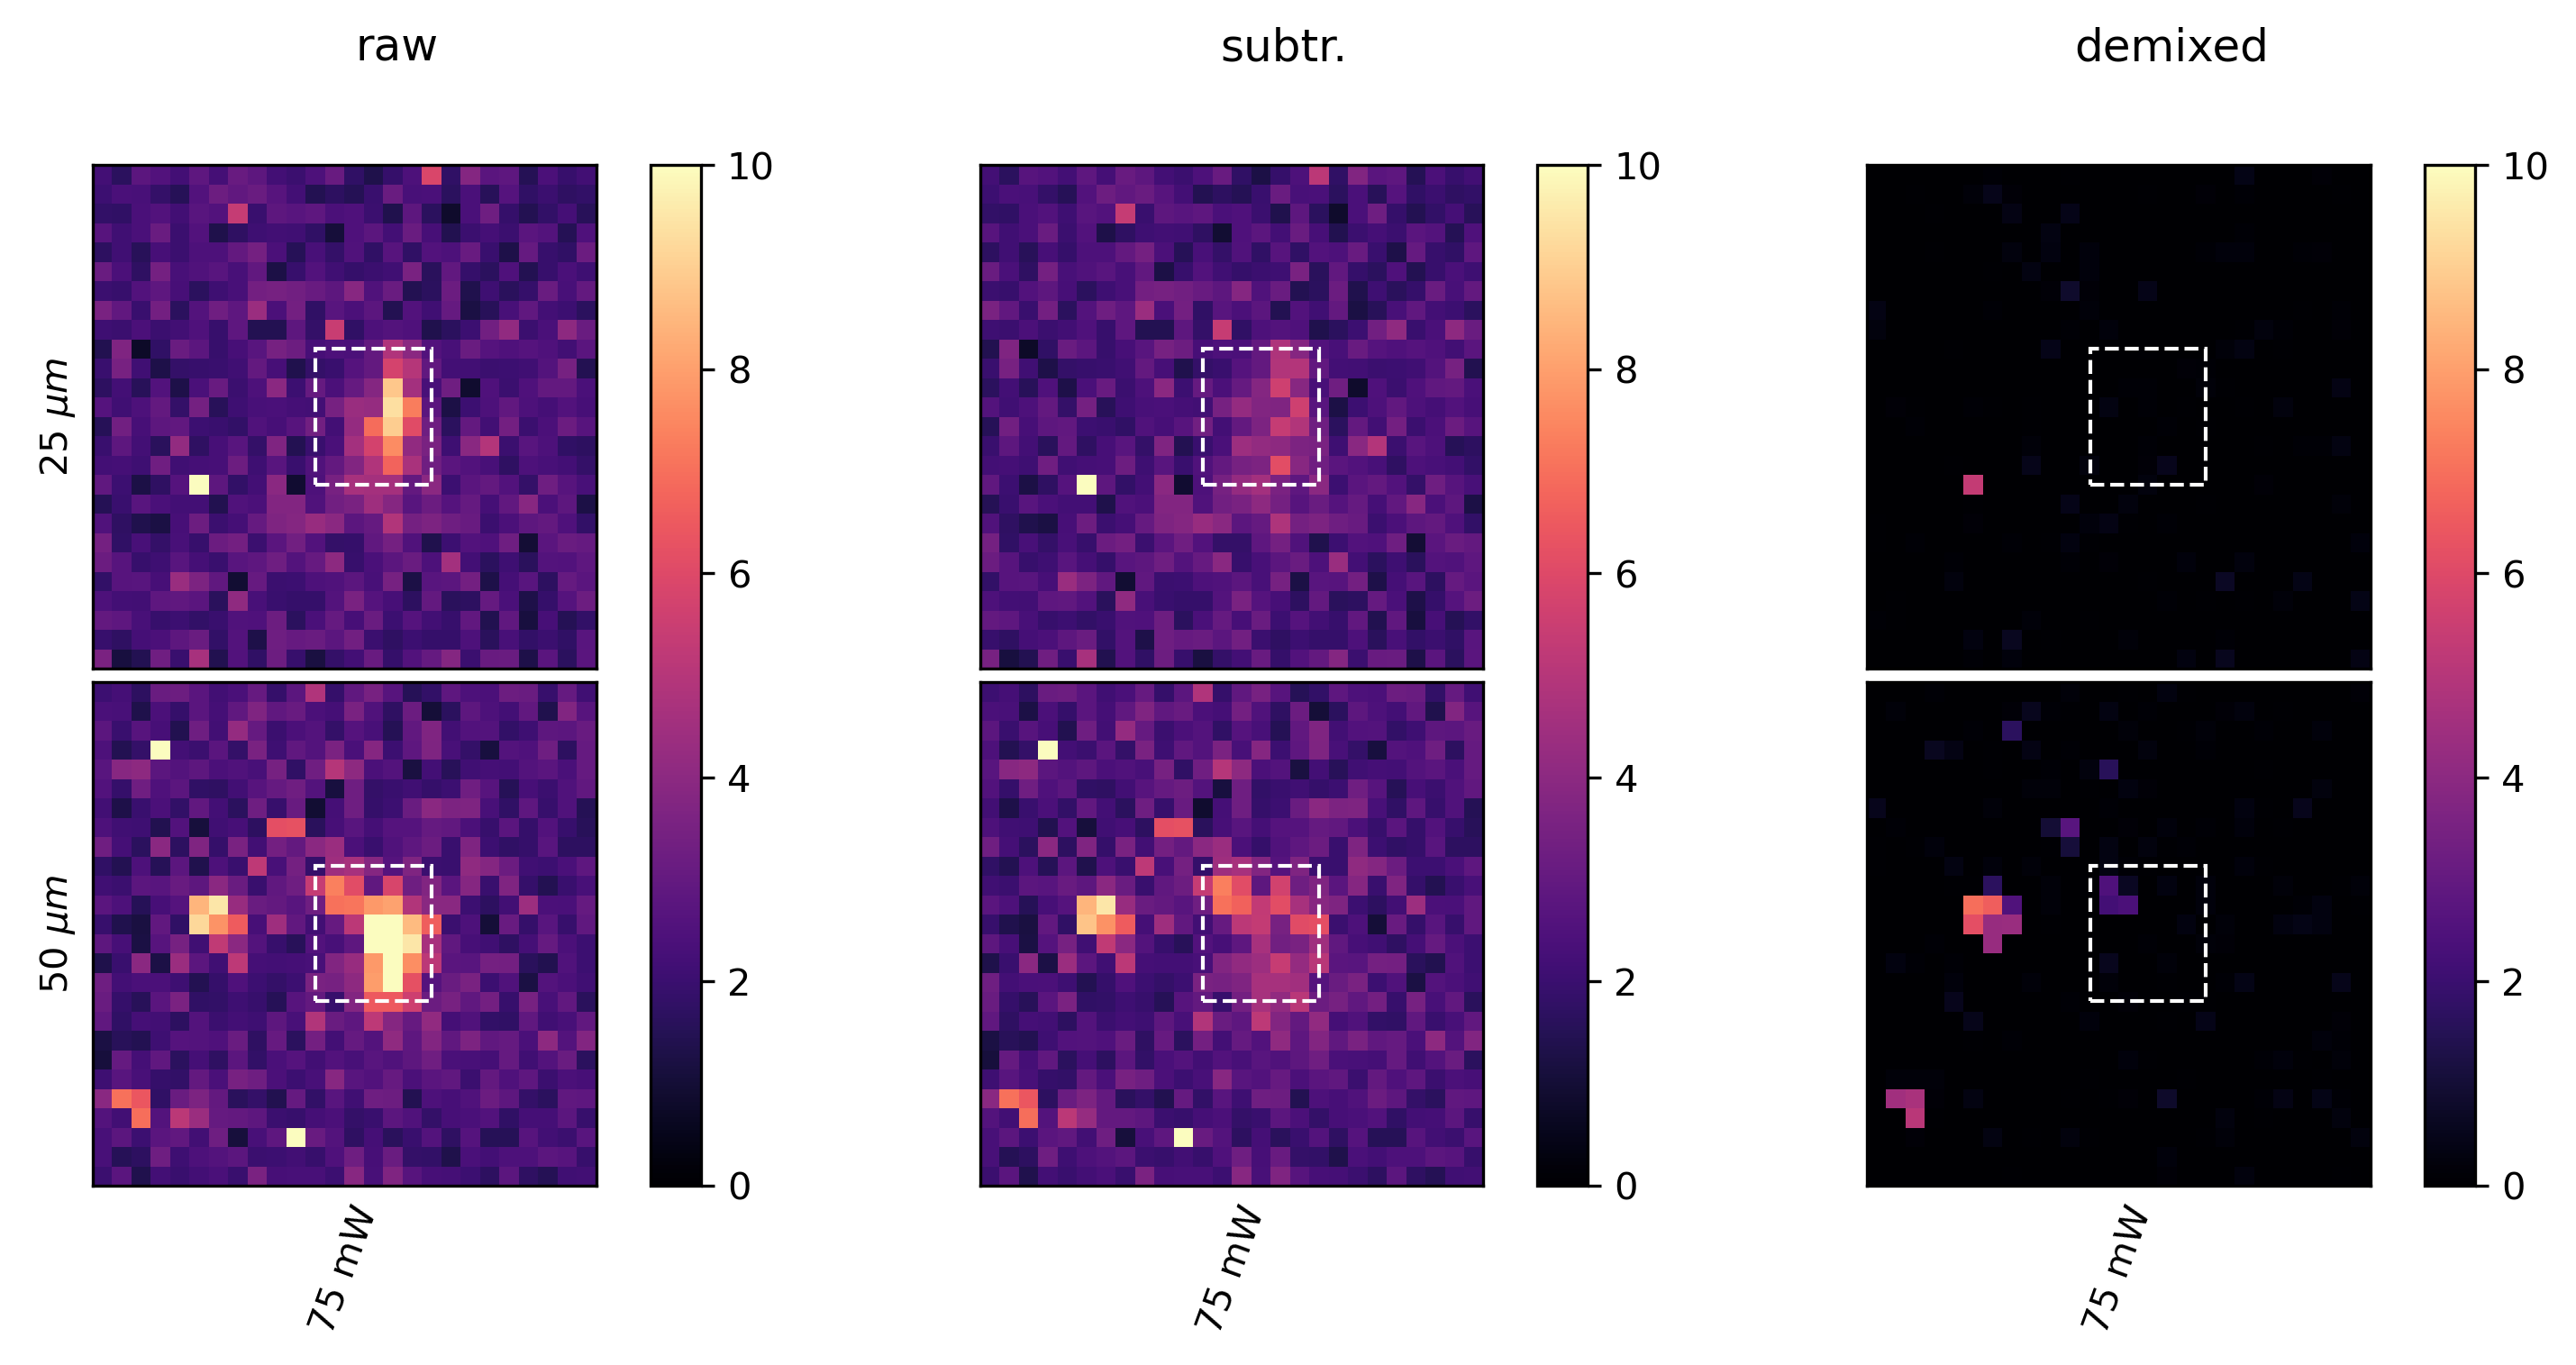

In [132]:
roi_bounds = (11, 9, 17, 16)
num_planes = results['raw_map'].shape[-1]
fig1 = plt.figure(figsize=(4 * 3, num_planes), dpi=300, facecolor='white')
plot_multi_means(fig1,
[
    results['raw_map'][2:3],
    results['subtracted_map'][2:3],
    results['demixed_map'][2:3],
], 
[1,2],
zs=np.unique(targets[:,-1]),
map_names=['raw', 'subtr.', 'demixed'],
cmaps=['magma', 'magma', 'magma', 'magma'],
# cbar_labels=['EPSQ (nC)'],
# zlabels=['subtr', 'demix'],
# map_names=['raw', 'subtr', 'demix'],
vranges=[(0,10), (0,10), (0,10), (0,10)],
powers=np.unique(powers)[2:3],
show_powers=(True, True, True, True),
roi_bounds=roi_bounds,
)

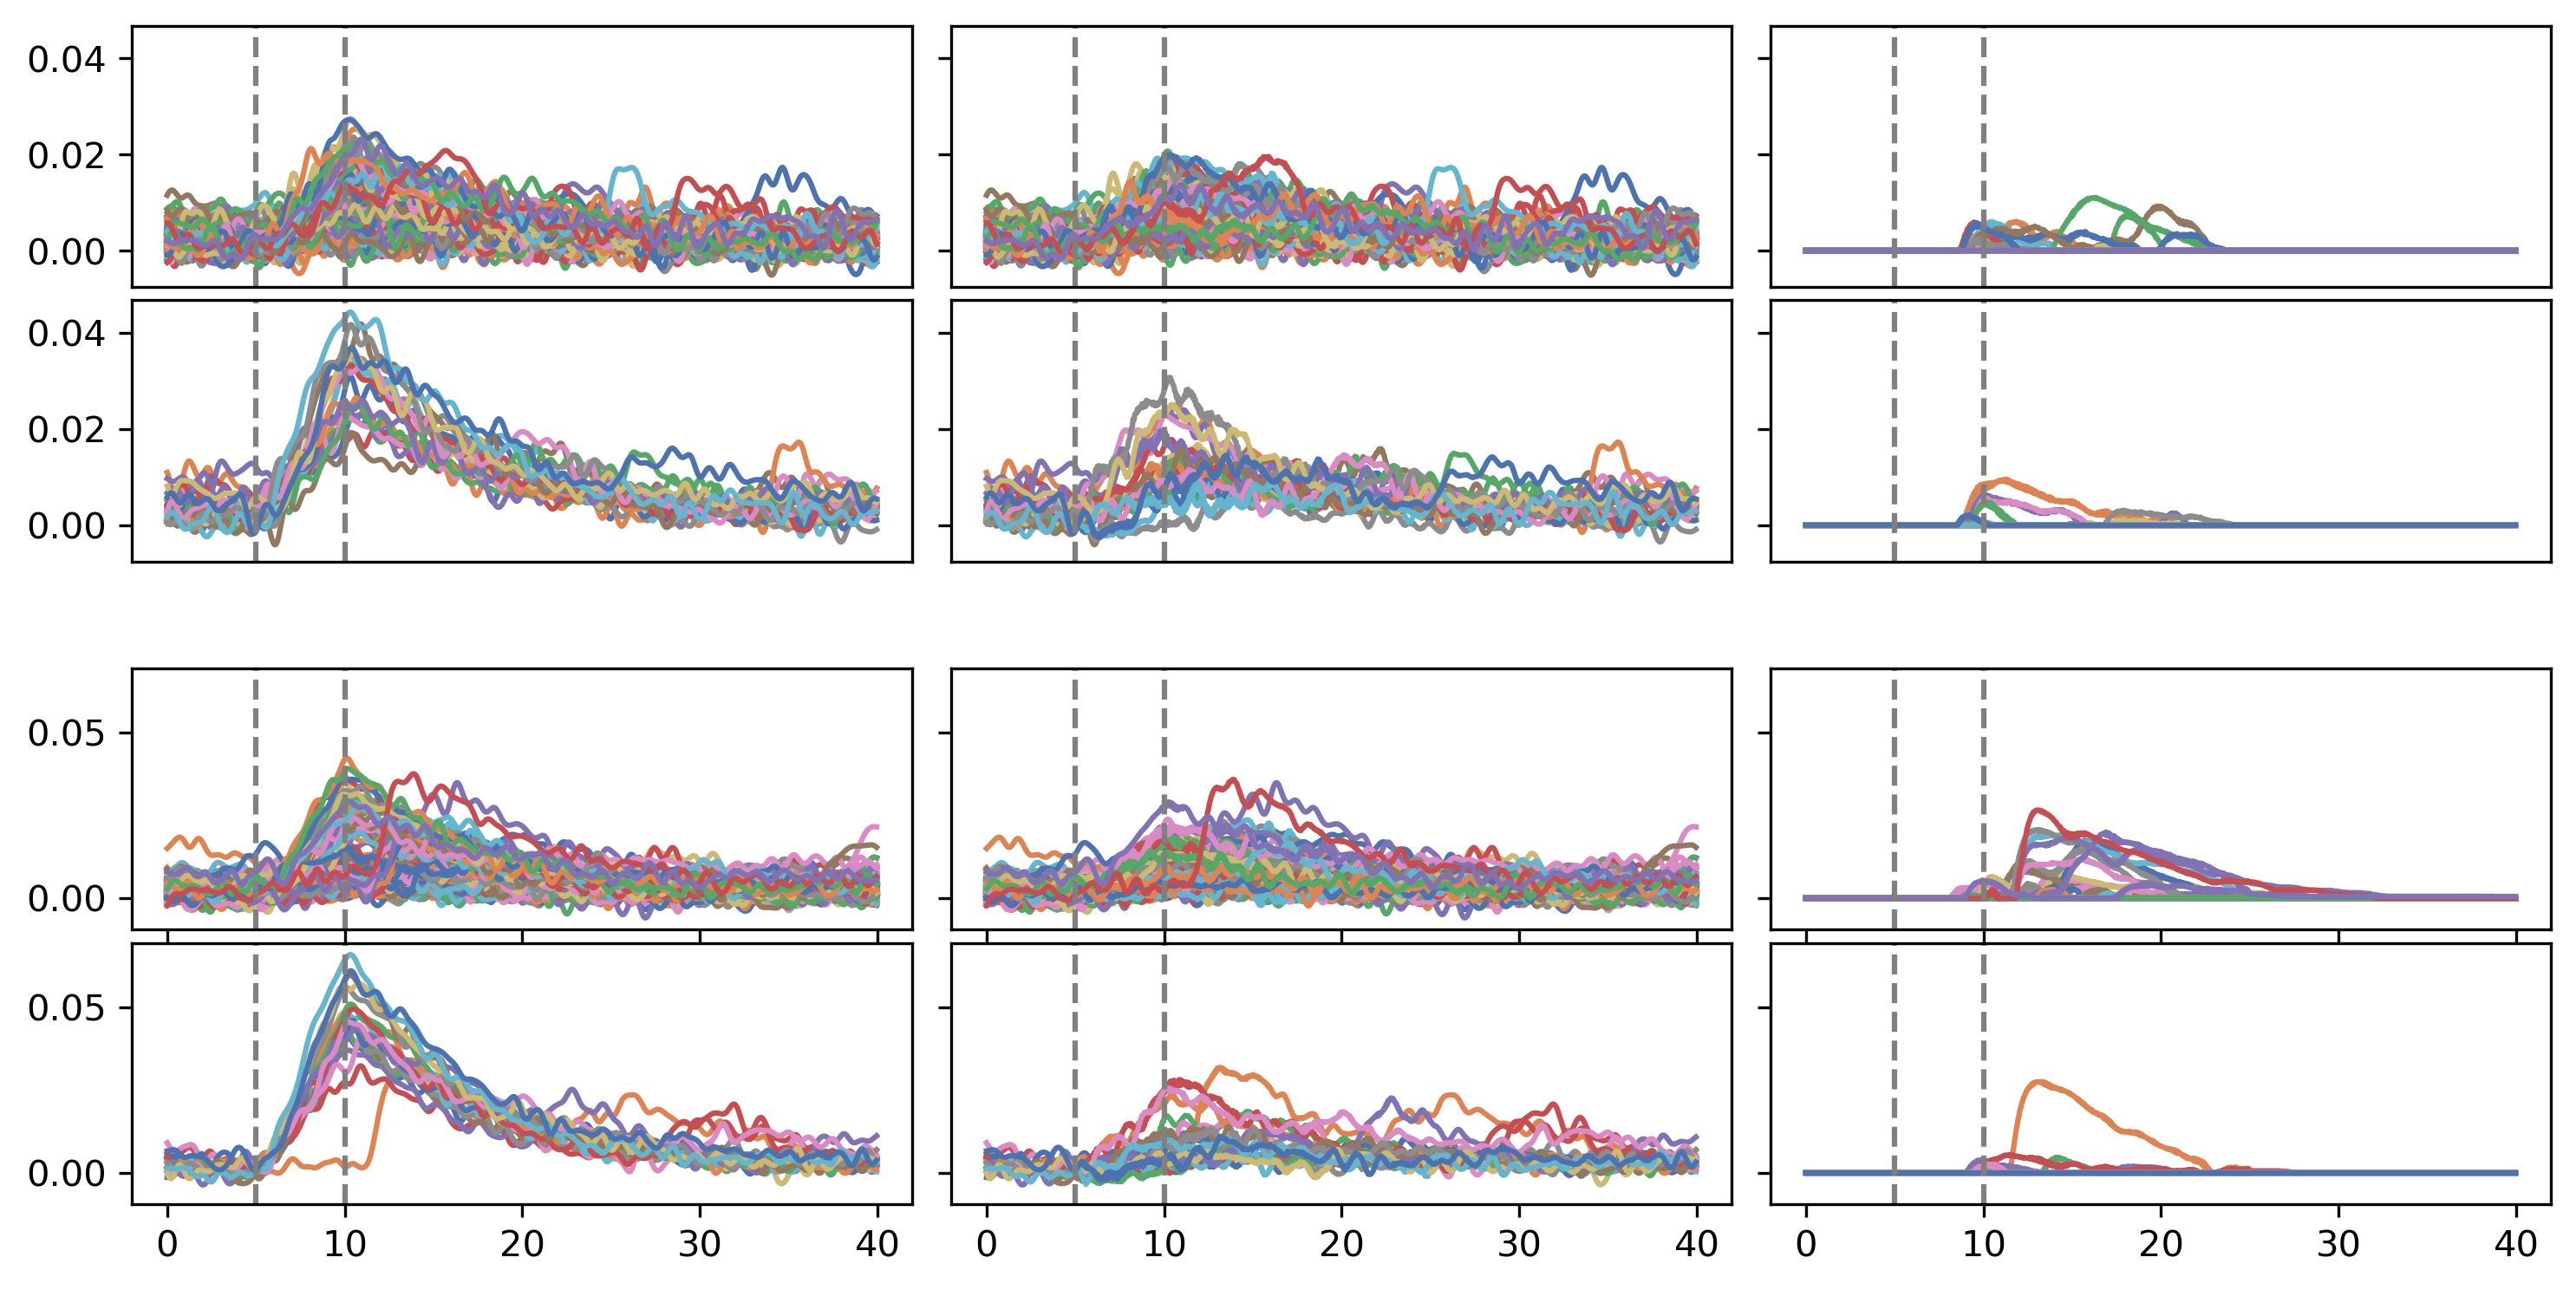

In [134]:
import seaborn as sns
sns.set_palette('deep')


roi_index = np.s_[2:, roi_bounds[1]:roi_bounds[3], roi_bounds[0]:roi_bounds[2], 1:3, :]
raw_tensor_roi = results['raw_tensor'][roi_index]
raw_map_roi = subtract_utils.traces_tensor_to_map(raw_tensor_roi)

subtracted_tensor_roi = results['subtracted_tensor'][roi_index]
subtracted_map_roi = subtract_utils.traces_tensor_to_map(subtracted_tensor_roi)

demixed_tensor_roi = results['demixed_tensor'][roi_index]
demixed_map_roi = subtract_utils.traces_tensor_to_map(demixed_tensor_roi)

num_plots_per_depth = 2
# fig, axs = plt.subplots(nrows=2 * num_plots_per_depth, ncols=3, figsize=(8,3), dpi=300, sharex=True, sharey=True)
tensors_list = [raw_tensor_roi, subtracted_tensor_roi, demixed_tensor_roi]
labels = ['raw', 'subtracted', 'demixed']
zs=np.unique(targets[:,-1])[1:3]
frame_cutoff = 800
msecs_per_samples = 0.05
time = np.arange(frame_cutoff) * msecs_per_samples

fig = plt.figure(figsize=(12,6), dpi=300)
outer_grid = GridSpec(2, 1, figure=fig)
for zidx, z in enumerate(zs):
    gs = gridspec.GridSpecFromSubplotSpec(2, 3, subplot_spec=outer_grid[zidx], wspace=0.05, hspace=0.05)
    axs = gs.subplots(sharey=True, sharex=True)
    # plt.figtext(x = 0.05, y=0.25 + (0.5 * zidx), s='z=x', rotation='vertical')
    for j in range(3):
        curr_tensor = tensors_list[j][:, :, :, zidx, :, :frame_cutoff].reshape(-1, frame_cutoff)

        # reset splits to match raw traces
        if j == 0:
            splits = np.split(np.argsort(np.sum(curr_tensor, axis=-1)), 2)

        for i in range(2):
            curr_traces = curr_tensor[splits[i]]

            axs[i,j].plot(time,
                curr_traces.T,
            )
            axs[i,j].axvline(x=5, color='grey', linestyle='--')
            axs[i,j].axvline(x=10, color='grey', linestyle='--')
            # get rid of x axes on first gspec
            if zidx == 0:
                axs[i,j].set_xticks([])






## dataset 3

In [80]:
datapath = '../data/marta/IV_injected_sparse/preprocessed/220214_cell2_mg_A_planes_cmReformat.mat'
subtractr_checkpoint = './grid_artifacts/happy-ptolemy-8225/happy-ptolemy-8225-exp0/scripts/lightning_logs/version_0/checkpoints/epoch=184-step=520404.ckpt'
demixer_checkpoint = '../../circuit_mapping/demixers/nwd_ee_ChroME1.ckpt'
pscs, stim_mat, powers, targets = util.load_h5_data(datapath)

net = cm.NeuralDemixer(
    path=subtractr_checkpoint,
    unet_args=dict(
            down_filter_sizes=(16, 32, 64, 128),
            up_filter_sizes=(64, 32, 16, 4),
    ))
results = subtract_utils.run_network_subtraction_pipeline(
    pscs, powers, targets, stim_mat,
    demixer_checkpoint, net,
    run_raw_demix=False,
)

Demixing PSC traces... complete (elapsed time 32.84s, device=cpu).


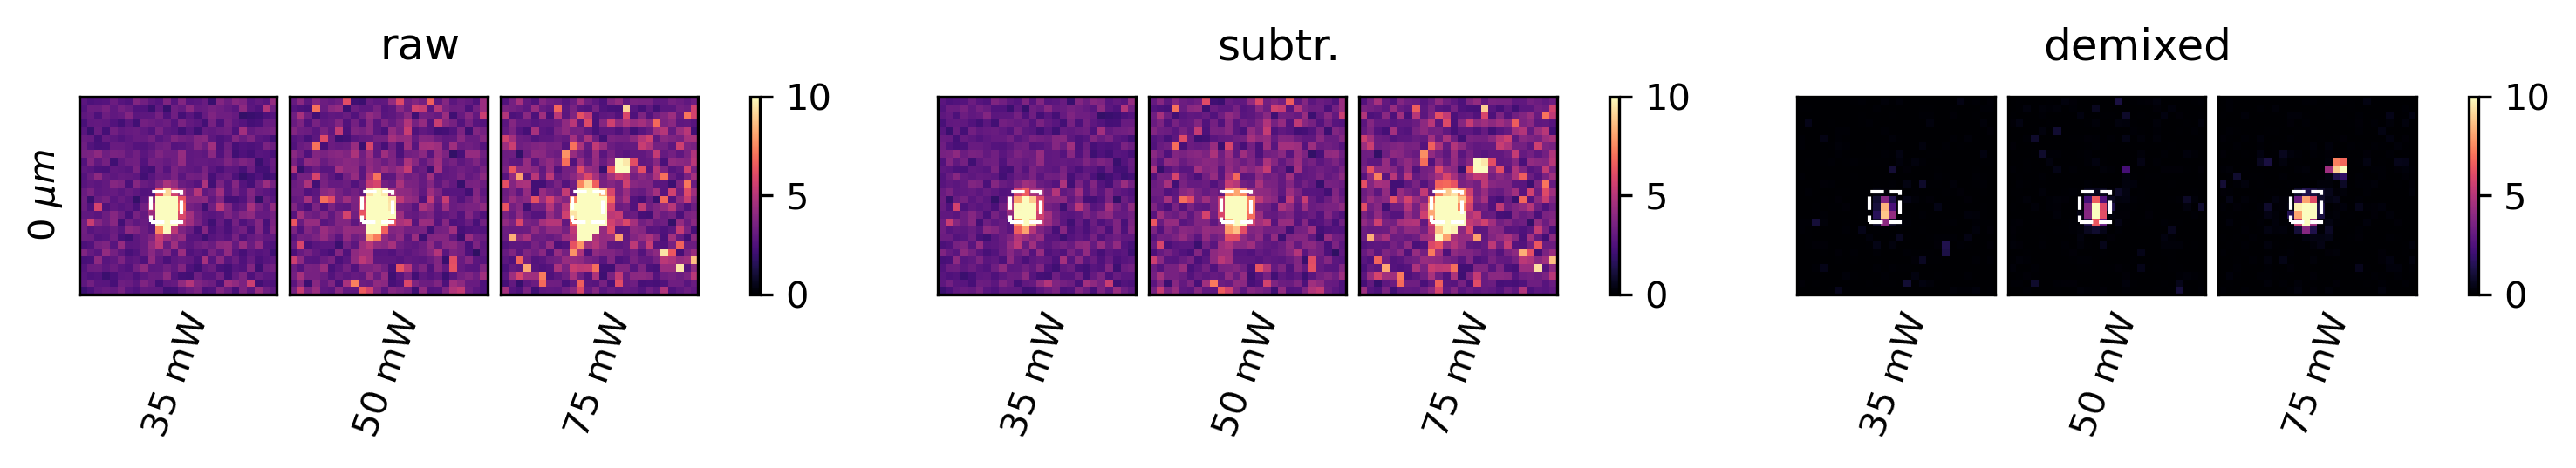

In [83]:
num_planes = results['raw_map'].shape[-1]
roi_bounds = (9, 9, 13, 13)
fig1 = plt.figure(figsize=(4 * 3, num_planes), dpi=300, facecolor='white')
plot_multi_means(fig1,
[
    results['raw_map'],
    results['subtracted_map'],
    results['demixed_map'],
], 
np.arange(num_planes),
zs=np.unique(targets[:,-1]),
map_names=['raw', 'subtr.', 'demixed'],
cmaps=['magma', 'magma', 'magma', 'magma'],
# cbar_labels=['EPSQ (nC)'],
# zlabels=['subtr', 'demix'],
# map_names=['raw', 'subtr', 'demix'],
vranges=[(0,10), (0,10), (0,10), (0,10)],
powers=np.unique(powers),
show_powers=(True, True, True, True),
roi_bounds=roi_bounds,
)

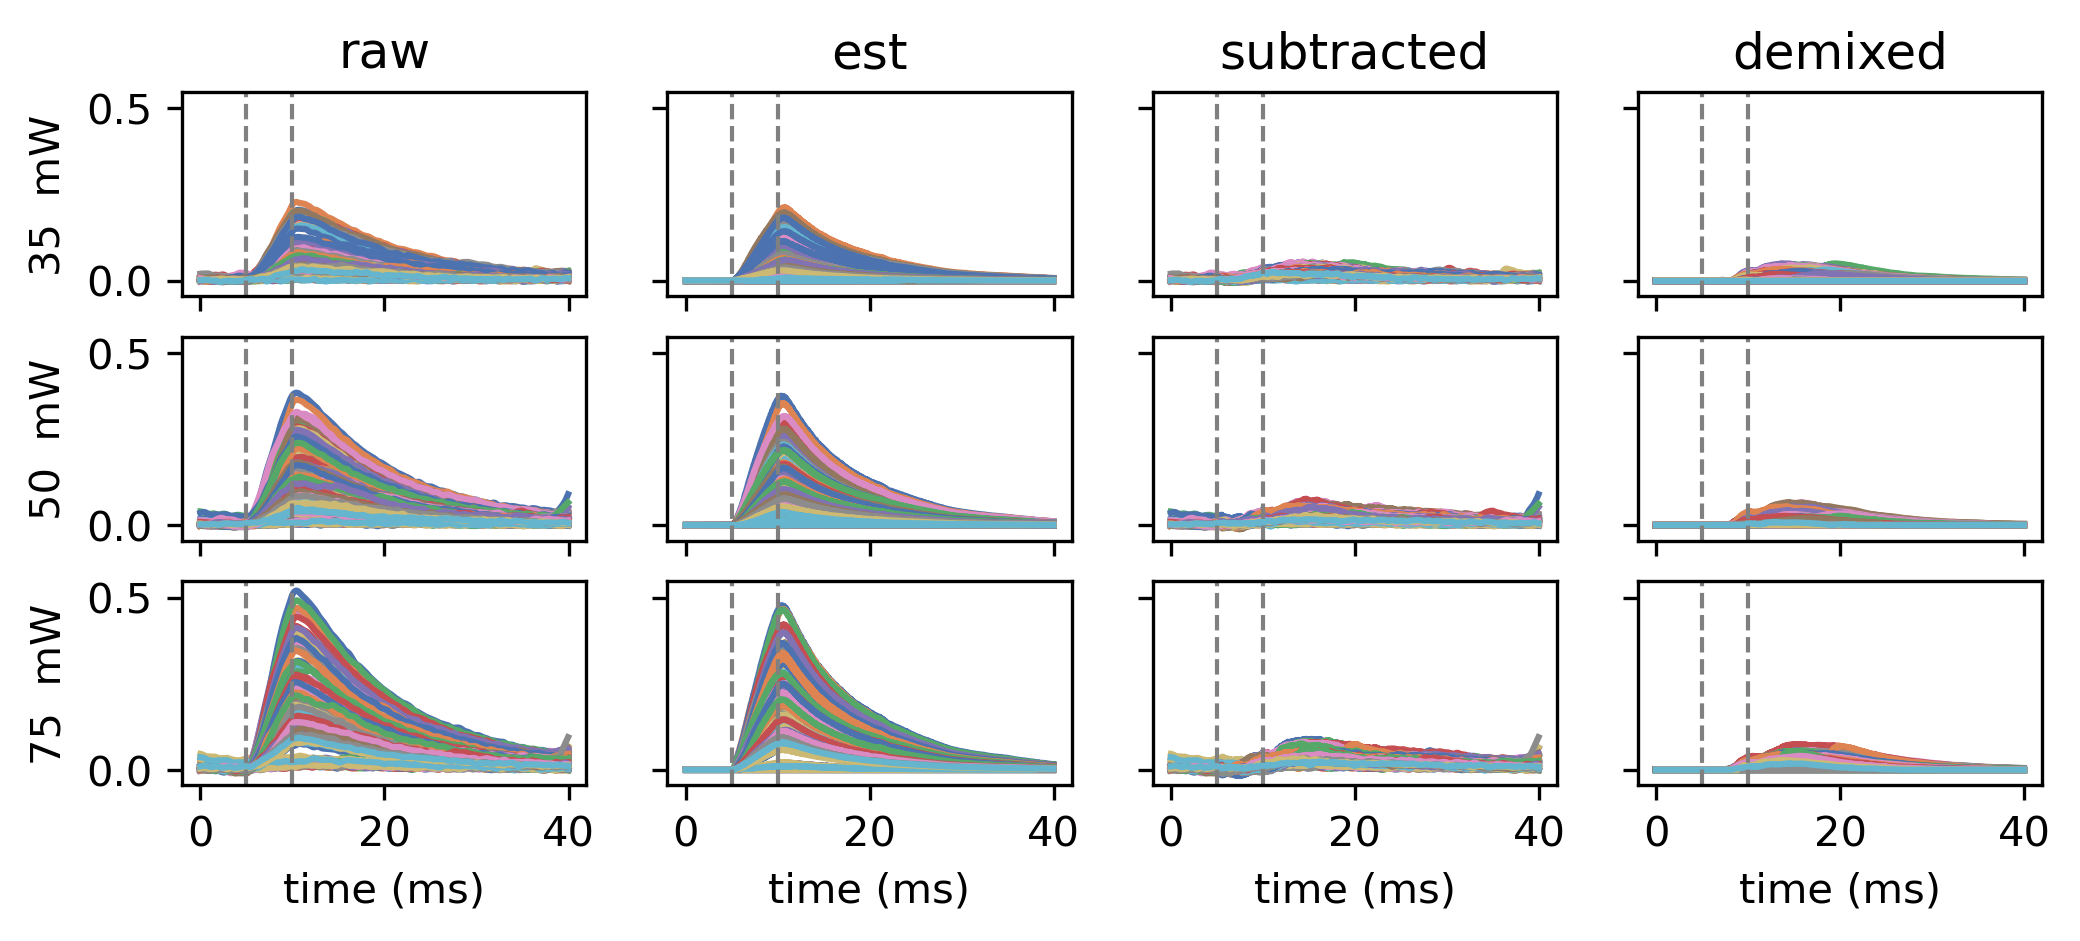

In [94]:
plt.rcParams.update(plt.rcParamsDefault)
import seaborn as sns
sns.set_palette('deep')



roi_index = np.s_[:, roi_bounds[1]:roi_bounds[3], roi_bounds[0]:roi_bounds[2], :, :]
raw_tensor_roi = results['raw_tensor'][roi_index]
raw_map_roi = subtract_utils.traces_tensor_to_map(raw_tensor_roi)

est_tensor_roi = results['est_tensor'][roi_index]
est_map_roi = subtract_utils.traces_tensor_to_map(est_tensor_roi)

subtracted_tensor_roi = results['subtracted_tensor'][roi_index]
subtracted_map_roi = subtract_utils.traces_tensor_to_map(subtracted_tensor_roi)

demixed_tensor_roi = results['demixed_tensor'][roi_index]
demixed_map_roi = subtract_utils.traces_tensor_to_map(demixed_tensor_roi)

fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(8,3), dpi=300, sharex=True, sharey=True)
tensors_list = [raw_tensor_roi, est_tensor_roi, subtracted_tensor_roi, demixed_tensor_roi]
labels = ['raw', 'est', 'subtracted', 'demixed']
zs=np.unique(targets[:,-1])
frame_cutoff = 800
msecs_per_samples = 0.05
time = np.arange(frame_cutoff) * msecs_per_samples
for i in range(3):
    for j in range(4):
        axs[i,j].plot(time,
            tensors_list[j][i, :, :, 0, :, :frame_cutoff].reshape(-1, frame_cutoff).T,
        )

        axs[i,j].axvline(x=5, linestyle='--', color='grey', linewidth=1.)
        axs[i,j].axvline(x=10, linestyle='--', color='grey', linewidth=1.)

        if j == 0:
            axs[i,j].set_ylabel('%d ' % np.unique(powers)[i] + ' mW')

        if i == 0:
            axs[i,j].set_title(labels[j])

        if i == 2:
            axs[i,j].set_xlabel('time (ms)')

## Key challenge: low-latency PSCs with large photocurrent
Make figure showing how hard it is to tell by eye

In [48]:
with h5py.File('../visualization/pc_examples_fastdecay.h5', 'r') as f:
    pc_templates = np.array(f['traces'])

# find some examples of pure EPSC
datapath = '../data/masato/B6WT_AAV_hsyn_chrome2f_gcamp8/preprocessed/220308_B6_Chrome2fGC8_030822_Cell2_opsPositive_A_planes_cmReformat.mat'
pscs, stim_mat, powers, targets = util.load_h5_data(datapath)
raw_tensor = util.make_psc_tensor_multispot(pscs, powers, targets, stim_mat)
raw_map = subtract_utils.traces_tensor_to_map(raw_tensor)

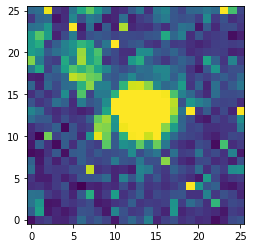

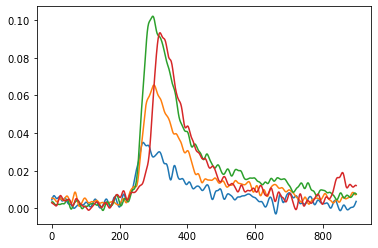

In [55]:
plt.imshow(raw_map[-1, :, :, -2], origin='lower', vmax=15)
plt.figure()
pscs = raw_tensor[-1, 17, 5, -2, :].reshape(-1,900)
plt.plot(pscs.T)

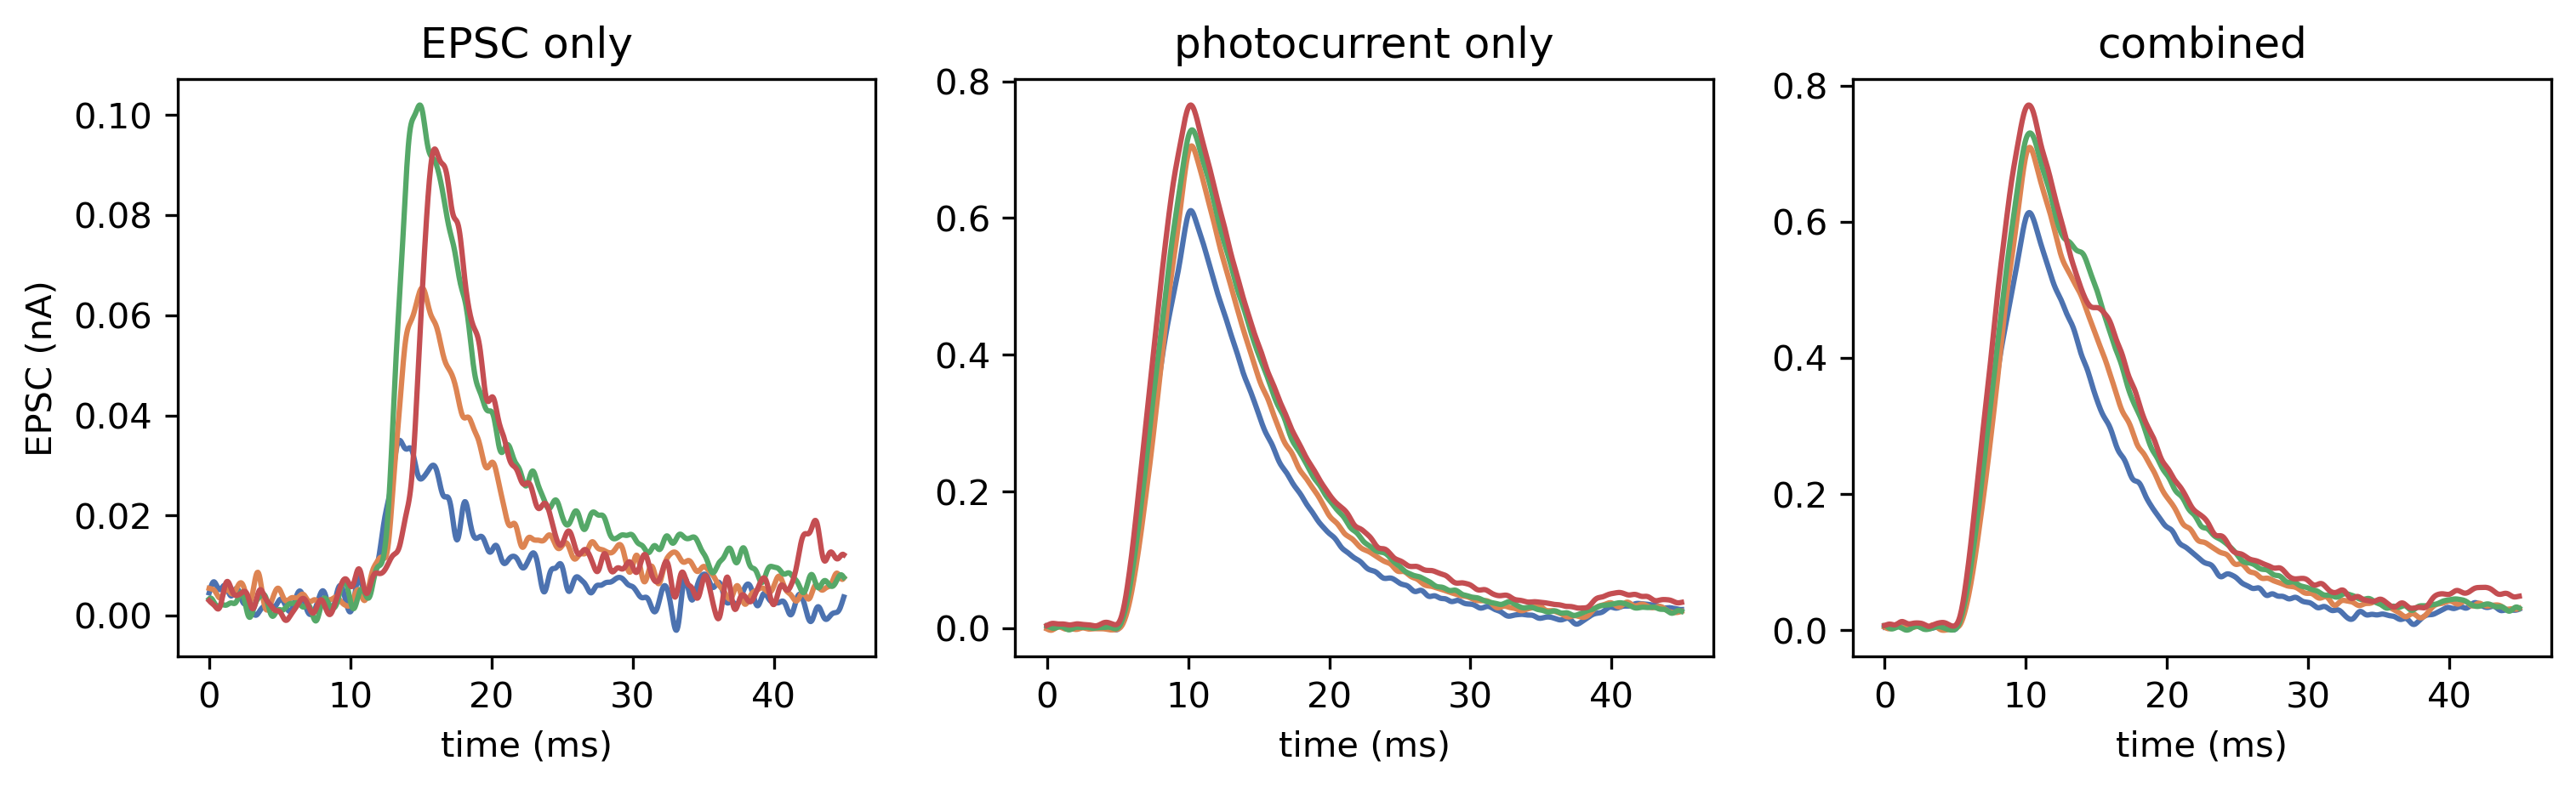

In [69]:
import seaborn as sns
sns.set_palette('deep')

fig, axs = plt.subplots(1, 3, sharey=False, dpi=300, figsize=(12,3))

combined = pc_templates[0:4] + pscs 
axs[0].plot(time, pscs.T)
axs[1].plot(time, pc_templates[0:4].T)
axs[2].plot(time, combined.T)

axs[0].set_title('EPSC only')
axs[0].set_ylabel('EPSC (nA)')
axs[1].set_title('photocurrent only')
axs[2].set_title('combined')

for ax in axs:
    ax.set_xlabel('time (ms)')

In [73]:
# find some examples of pure EPSC from ai203
datapath = '../data/marta/ai203/preprocessed/201118_cell1_A_cmFormat.mat'
pscs, stim_mat, powers, targets = util.load_h5_data(datapath)
raw_tensor = util.make_psc_tensor_multispot(pscs, powers, targets, stim_mat)
raw_map = subtract_utils.traces_tensor_to_map(raw_tensor)


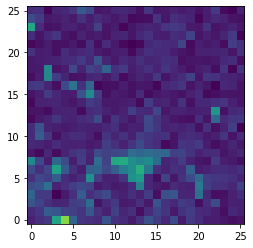

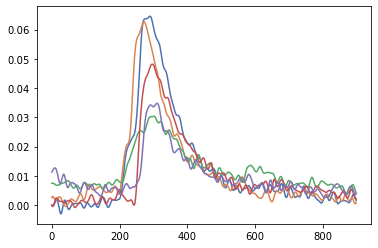

In [80]:

plt.imshow(raw_map[-1, :, :, 0], origin='lower', vmax=15)
plt.figure()
pscs = raw_tensor[-1, 6, 12, 0, :].reshape(-1,900)
idxs = np.argsort(pscs.sum(-1))[::-1]
pscs = pscs[idxs[0:5]]
plt.plot(pscs.T)

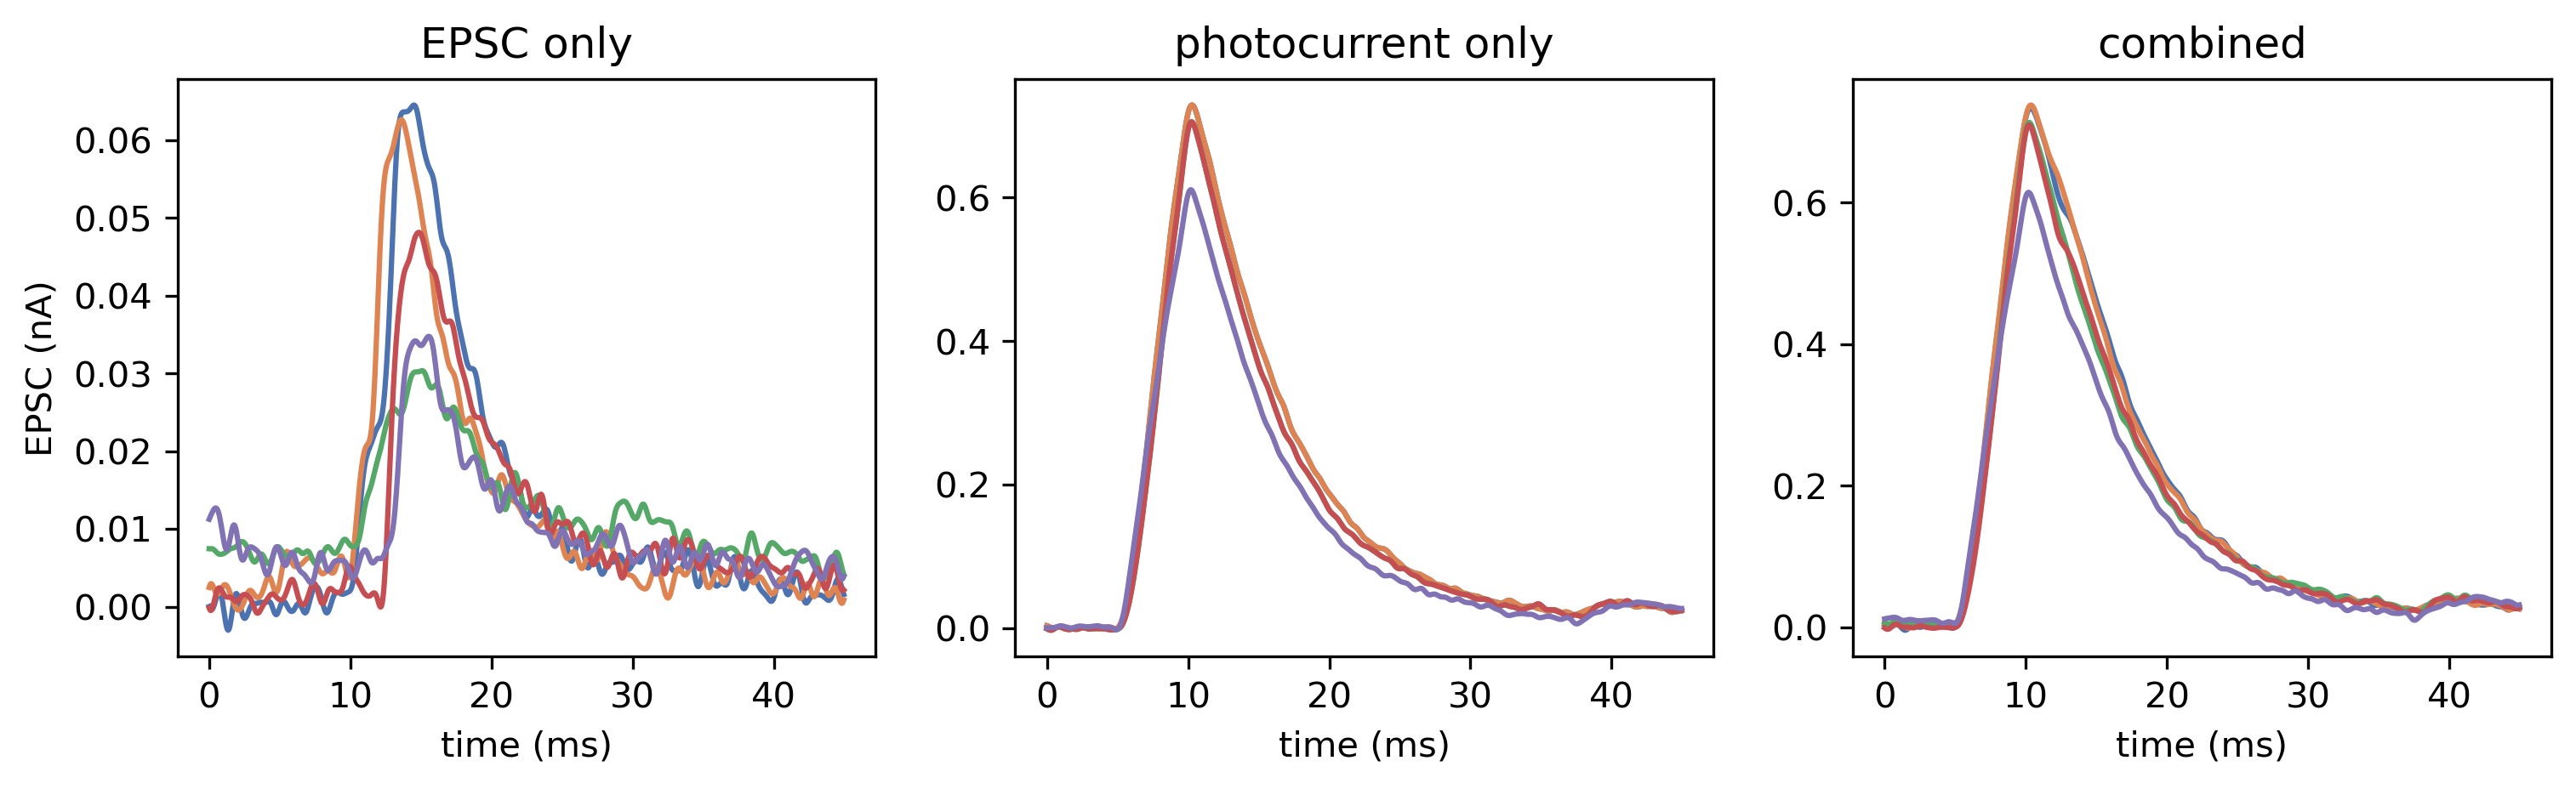

In [87]:
fig, axs = plt.subplots(1, 3, sharey=False, dpi=300, figsize=(12,3))

pc_templates = pc_templates[np.argsort(pc_templates.sum(-1))[::-1]]
combined = pc_templates[1:6] + pscs 
axs[0].plot(time, pscs.T)
axs[1].plot(time, pc_templates[1:6].T)
axs[2].plot(time, combined.T)

axs[0].set_title('EPSC only')
axs[0].set_ylabel('EPSC (nA)')
axs[1].set_title('photocurrent only')
axs[2].set_title('combined')

for ax in axs:
    ax.set_xlabel('time (ms)')

## validation
negative control: synaptic blocker dset

positive control: synaptic blocker dset + synthetic PSCs

**show example of synaptic blocker dataset before/after**

In [125]:
datapath = '../data/masato/B6WT_AAV_hsyn_chrome2f_gcamp8/preprocessed/220630_B6_Chrome2fGC8_IC_063022_Cell3_SingleSpot_Control_A_planes_cmReformat.mat'
pscs, stim_mat, powers, targets = util.load_h5_data(datapath)
raw_tensor = util.make_psc_tensor_multispot(pscs, powers, targets, stim_mat)
raw_map = subtract_utils.traces_tensor_to_map(raw_tensor)

demix_results = subtract_utils.run_subtraction_pipeline(
    pscs, powers, targets, stim_mat, demixer_checkpoint, no_op=True,
)
demixed_before = demix_results['demixed_map']

In [126]:
datapath = '../data/masato/B6WT_AAV_hsyn_chrome2f_gcamp8/preprocessed/220630_B6_Chrome2fGC8_IC_063022_Cell3_SingleSpot_KynA_A_planes_cmReformat.mat'
pscs, stim_mat, powers, targets = util.load_h5_data(datapath)

demix_results = subtract_utils.run_subtraction_pipeline(
    pscs, powers, targets, stim_mat, demixer_checkpoint, no_op=True,
)
demixed_after = demix_results['demixed_map']

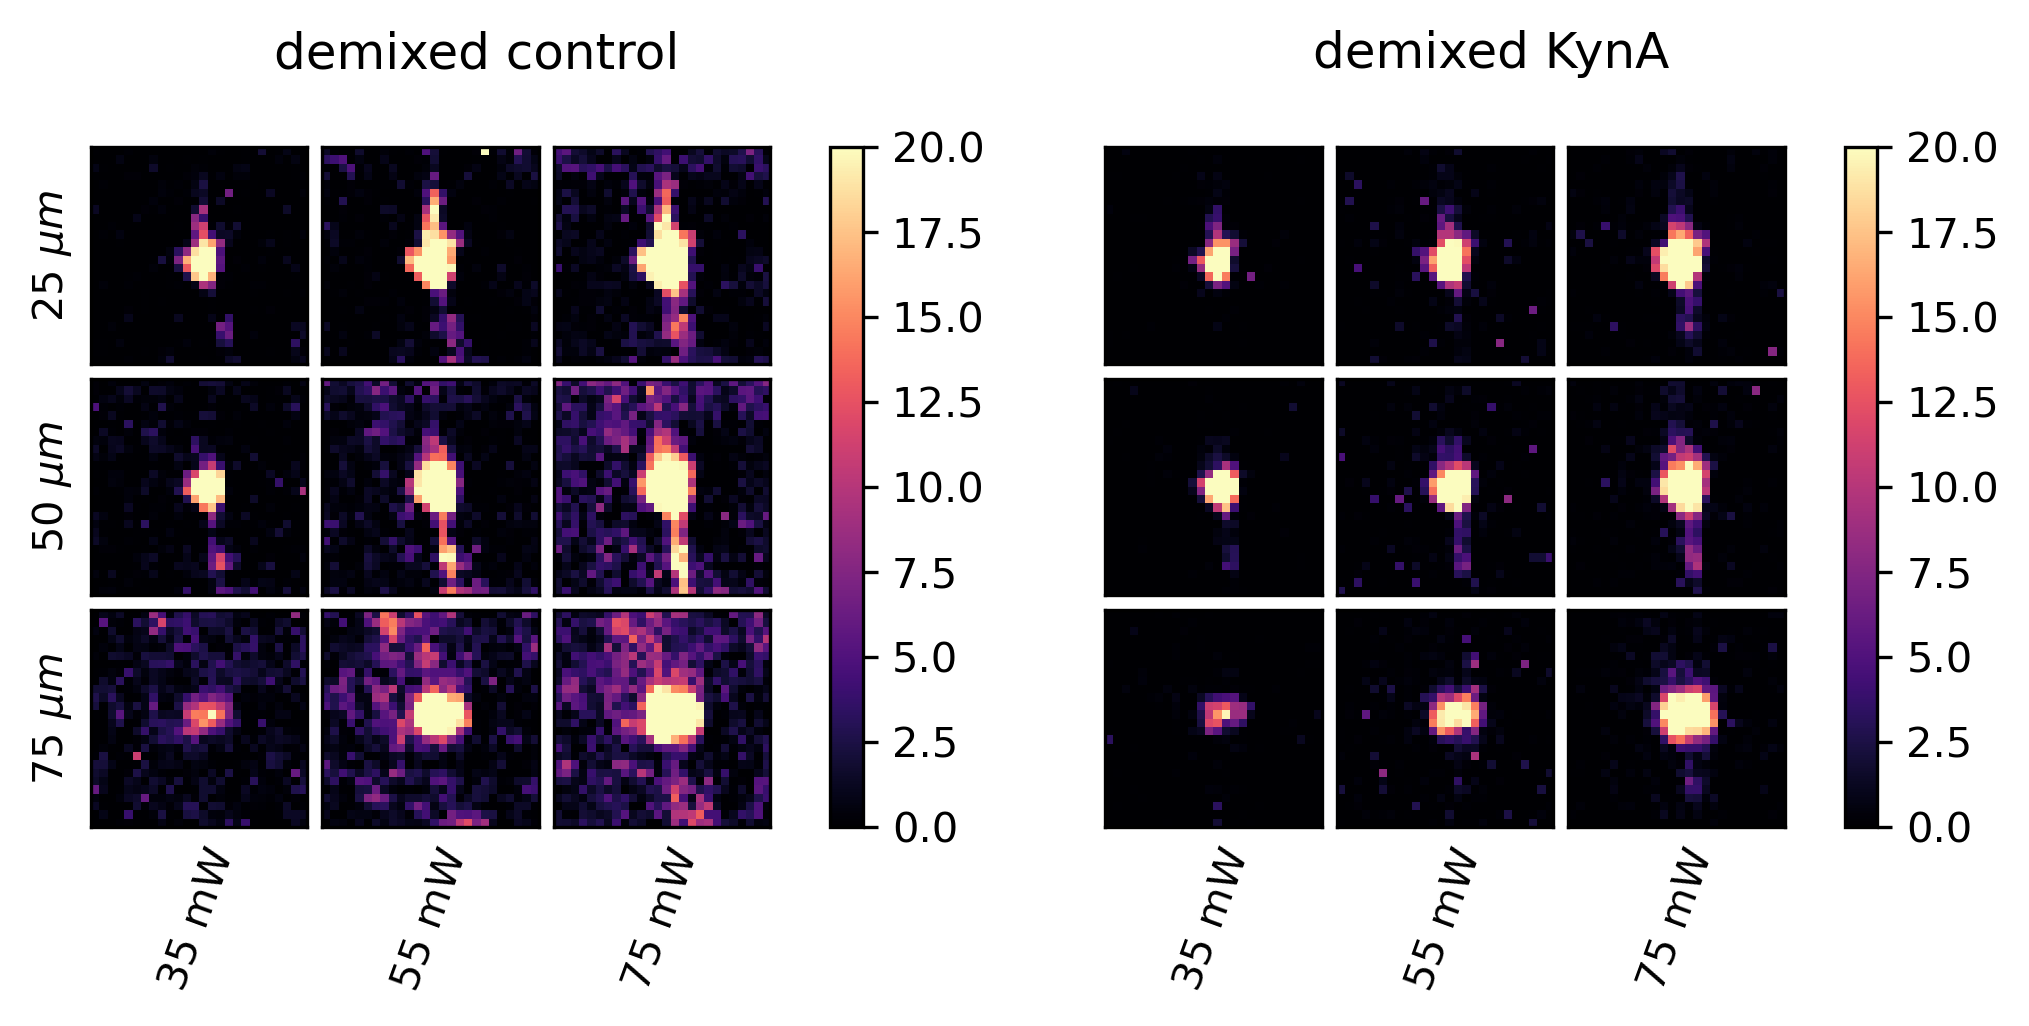

In [130]:
num_planes = results['raw_map'].shape[-1]
fig1 = plt.figure(figsize=(4 * 2, 3), dpi=300, facecolor='white')
plot_multi_means(fig1,
[
    demixed_before,
    demixed_after,
], 
[1,2,3],
zs=np.unique(targets[:,-1]),
map_names=['demixed control', 'demixed KynA', 'demixed'],
cmaps=['magma', 'magma', 'magma', 'magma'],
# cbar_labels=['EPSQ (nC)'],
# zlabels=['subtr', 'demix'],
# map_names=['raw', 'subtr', 'demix'],
vranges=[(0,20), (0,20), (0,10), (0,10)],
powers=np.unique(powers),
show_powers=(True, True, True, True),
)